In [1]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
import pertpy 

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

pd.set_option('display.max_columns', None)

%load_ext rpy2.ipython

In [2]:
%%R
library(GSA)
library(msigdbr)
library(fgsea)
library(tidyverse) # includes ggplot2, for data visualisation. dplyr, for data manipulation.
library(RColorBrewer) # for a colourful plot

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [3]:
%%R

set.seed(42)

# Set up gene lists

In [4]:
%%R
msigdbr_species()

# A tibble: 20 × 2
   species_name                    species_common_name                          
   <chr>                           <chr>                                        
 1 Anolis carolinensis             Carolina anole, green anole                  
 2 Bos taurus                      bovine, cattle, cow, dairy cow, domestic cat…
 3 Caenorhabditis elegans          <NA>                                         
 4 Canis lupus familiaris          dog, dogs                                    
 5 Danio rerio                     leopard danio, zebra danio, zebra fish, zebr…
 6 Drosophila melanogaster         fruit fly                                    
 7 Equus caballus                  domestic horse, equine, horse                
 8 Felis catus                     cat, cats, domestic cat                      
 9 Gallus gallus                   bantam, chicken, chickens, Gallus domesticus 
10 Homo sapiens                    human                                        
11 Macaca

In [5]:
%%R

all_gene_sets = msigdbr(species = "human")
head(all_gene_sets)

# A tibble: 6 × 15
  gs_cat gs_subcat      gs_name        gene_symbol entrez_gene ensembl_gene   
  <chr>  <chr>          <chr>          <chr>             <int> <chr>          
1 C3     MIR:MIR_Legacy AAACCAC_MIR140 ABCC4             10257 ENSG00000125257
2 C3     MIR:MIR_Legacy AAACCAC_MIR140 ABRAXAS2          23172 ENSG00000165660
3 C3     MIR:MIR_Legacy AAACCAC_MIR140 ACTN4                81 ENSG00000130402
4 C3     MIR:MIR_Legacy AAACCAC_MIR140 ACTN4                81 ENSG00000282844
5 C3     MIR:MIR_Legacy AAACCAC_MIR140 ACVR1                90 ENSG00000115170
6 C3     MIR:MIR_Legacy AAACCAC_MIR140 ADAM9              8754 ENSG00000168615
# ℹ 9 more variables: human_gene_symbol <chr>, human_entrez_gene <int>,
#   human_ensembl_gene <chr>, gs_id <chr>, gs_pmid <chr>, gs_geoid <chr>,
#   gs_exact_source <chr>, gs_url <chr>, gs_description <chr>


In [6]:
%%R

# Get the MSigDB collections
collections <- msigdbr_collections()

# Print all rows of the tibble
print(collections, n = Inf)

# A tibble: 23 × 3
   gs_cat gs_subcat         num_genesets
   <chr>  <chr>                    <int>
 1 C1     ""                         299
 2 C2     "CGP"                     3384
 3 C2     "CP"                        29
 4 C2     "CP:BIOCARTA"              292
 5 C2     "CP:KEGG"                  186
 6 C2     "CP:PID"                   196
 7 C2     "CP:REACTOME"             1615
 8 C2     "CP:WIKIPATHWAYS"          664
 9 C3     "MIR:MIRDB"               2377
10 C3     "MIR:MIR_Legacy"           221
11 C3     "TFT:GTRD"                 518
12 C3     "TFT:TFT_Legacy"           610
13 C4     "CGN"                      427
14 C4     "CM"                       431
15 C5     "GO:BP"                   7658
16 C5     "GO:CC"                   1006
17 C5     "GO:MF"                   1738
18 C5     "HPO"                     5071
19 C6     ""                         189
20 C7     "IMMUNESIGDB"             4872
21 C7     "VAX"                      347
22 C8     ""                         7

In [7]:
%%R

#Retrieve human H (hallmark gene sets) 
msigdbr_df <- msigdbr(species = "human", category = "H")


head(msigdbr_df)

# A tibble: 6 × 15
  gs_cat gs_subcat gs_name               gene_symbol entrez_gene ensembl_gene   
  <chr>  <chr>     <chr>                 <chr>             <int> <chr>          
1 H      ""        HALLMARK_ADIPOGENESIS ABCA1                19 ENSG00000165029
2 H      ""        HALLMARK_ADIPOGENESIS ABCB8             11194 ENSG00000197150
3 H      ""        HALLMARK_ADIPOGENESIS ACAA2             10449 ENSG00000167315
4 H      ""        HALLMARK_ADIPOGENESIS ACADL                33 ENSG00000115361
5 H      ""        HALLMARK_ADIPOGENESIS ACADM                34 ENSG00000117054
6 H      ""        HALLMARK_ADIPOGENESIS ACADS                35 ENSG00000122971
# ℹ 9 more variables: human_gene_symbol <chr>, human_entrez_gene <int>,
#   human_ensembl_gene <chr>, gs_id <chr>, gs_pmid <chr>, gs_geoid <chr>,
#   gs_exact_source <chr>, gs_url <chr>, gs_description <chr>


In [8]:
%%R

pathwaysH = split(x = msigdbr_df$gene_symbol, f = msigdbr_df$gs_name)
head(pathwaysH)

$HALLMARK_ADIPOGENESIS
  [1] "ABCA1"    "ABCB8"    "ACAA2"    "ACADL"    "ACADM"    "ACADS"   
  [7] "ACLY"     "ACO2"     "ACOX1"    "ADCY6"    "ADIG"     "ADIPOQ"  
 [13] "ADIPOR2"  "ADIPOR2"  "AGPAT3"   "AIFM1"    "AK2"      "ALDH2"   
 [19] "ALDOA"    "ANGPT1"   "ANGPTL4"  "APLP2"    "APOE"     "ARAF"    
 [25] "ARL4A"    "ATL2"     "ATP1B3"   "ATP5PO"   "BAZ2A"    "BCKDHA"  
 [31] "BCL2L13"  "BCL6"     "C3"       "CAT"      "CAVIN1"   "CAVIN2"  
 [37] "CCNG2"    "CD151"    "CD302"    "CD36"     "CDKN2C"   "CHCHD10" 
 [43] "CHCHD10"  "CHCHD10"  "CHUK"     "CIDEA"    "CMBL"     "CMPK1"   
 [49] "COL15A1"  "COL4A1"   "COQ3"     "COQ5"     "COQ9"     "COX6A1"  
 [55] "COX7B"    "COX8A"    "CPT2"     "CRAT"     "CS"       "CYC1"    
 [61] "CYP4B1"   "DBT"      "DDT"      "DDT"      "DECR1"    "DGAT1"   
 [67] "DGAT1"    "DGAT1"    "DHCR7"    "DHRS7"    "DHRS7B"   "DLAT"    
 [73] "DLD"      "DNAJB9"   "DNAJC15"  "DRAM2"    "ECH1"     "ECH1"    
 [79] "ECHS1"    "ELMOD3"   "ELOVL6"   "E

[25] "S100A4"   "SERPINA5" "SLCO2A1"  "SPP1"     "STC1"     "THBD"    
[31] "TIMP1"    "TNFRSF21" "VAV2"     "VCAN"     "VEGFA"    "VTN"     

$HALLMARK_APICAL_JUNCTION
  [1] "ACTA1"     "ACTB"      "ACTC1"     "ACTG1"     "ACTG2"     "ACTN1"    
  [7] "ACTN2"     "ACTN3"     "ACTN4"     "ACTN4"     "ADAM15"    "ADAM23"   
 [13] "ADAM9"     "ADAM9"     "ADAMTS5"   "ADRA1B"    "AKT2"      "AKT3"     
 [19] "AKT3"      "ALOX15B"   "AMH"       "AMIGO1"    "AMIGO2"    "ARHGEF6"  
 [25] "ARPC2"     "ATP1A3"    "B4GALT1"   "BAIAP2"    "BMP1"      "CADM2"    
 [31] "CADM3"     "CALB2"     "CALB2"     "CAP1"      "CD209"     "CD274"    
 [37] "CD276"     "CD34"      "CD86"      "CD99"      "CDH1"      "CDH11"    
 [43] "CDH15"     "CDH3"      "CDH4"      "CDH4"      "CDH6"      "CDH8"     
 [49] "CDK8"      "CDSN"      "CDSN"      "CDSN"      "CDSN"      "CDSN"     
 [55] "CDSN"      "CERCAM"    "CLDN11"    "CLDN14"    "CLDN15"    "CLDN18"   
 [61] "CLDN19"    "CLDN4"     "CLDN5"     "CLDN6"  

In [9]:
%%R

options(ports=8888)

# MG_D

In [10]:
%%R

# Replace the file path with the actual path if the file is not in the current directory
df <- read.csv("./files/MG_DvA_WM_v_AL_dream.csv")
head(df)  # Display the first few rows of the data frame to confirm it's loaded correctly

        gene     logFC  AveExpr         t      P.Value    adj.P.Val        B
1      MYO1E -3.663872 9.429126 -15.18508 6.851893e-13 3.117062e-09 19.47887
2      IL6ST  2.269453 8.269909  15.18008 6.896154e-13 3.117062e-09 19.40867
3      ABCC4  2.112693 9.257283  13.78714 4.456471e-12 1.342883e-08 17.70702
4       BLNK  1.892693 8.376377  12.96649 1.439085e-11 3.252332e-08 16.58454
5 ST6GALNAC3  3.418599 9.508784  12.25627 4.164442e-11 7.529310e-08 15.54699
6   ARHGAP10 -6.837440 5.090533 -11.56095 1.302805e-10 1.364180e-07 10.22755
      z.std     gene.1
1 -7.182359      MYO1E
2  7.181478      IL6ST
3  6.921893      ABCC4
4  6.753915       BLNK
5  6.598106 ST6GALNAC3
6 -6.426844   ARHGAP10


In [11]:
%%R

# Assign names to the rankings
df$logFC <- df$logFC * -1

In [12]:
%%R

# Define the gene of interest
gene_of_interest <- "SPP1"  # Replace with the gene you want to search for

# Filter the data frame to find the row corresponding to the gene
gene_row <- df[df$gene == gene_of_interest, ]

# Print the row corresponding to the gene
if (nrow(gene_row) > 0) {
  print("Details for the gene of interest:")
  print(gene_row)
} else {
  cat("Gene", gene_of_interest, "not found in the data frame.\n")
}

[1] "Details for the gene of interest:"
    gene    logFC  AveExpr         t      P.Value    adj.P.Val        B
220 SPP1 2.180643 11.93158 -6.782775 3.718945e-06 0.0001528148 2.294629
        z.std gene.1
220 -4.626501   SPP1


In [13]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_up <- df[df$adj.P.Val < 0.05 & df$logFC > 0.585, ]
num_genes_up <- nrow(genes_up)

# Print the number of significant genes
print(num_genes_up)

genes_up_sorted <- genes_up[order(genes_up$logFC, decreasing = TRUE), ]

# View the head of the significant genes data frame
head(genes_up_sorted)

[1] 1050
          gene    logFC  AveExpr          t      P.Value    adj.P.Val
600    FAM135B 7.021303 4.235859  -4.599519 1.510290e-04 2.275503e-03
120       RGCC 6.957488 4.047022  -7.204832 4.111661e-07 3.090140e-05
6     ARHGAP10 6.837440 5.090533 -11.560948 1.302805e-10 1.364180e-07
20         LPL 6.305634 5.514095 -10.375745 8.875418e-10 4.011689e-07
97  AP002991.1 6.188649 3.722259  -7.664251 1.585407e-07 1.474017e-05
197     MAMLD1 5.985150 4.004271  -6.398347 2.550441e-06 1.170355e-04
             B     z.std     gene.1
600  0.4049163 -3.789371    FAM135B
120  6.0578546 -5.063714       RGCC
6   10.2275475 -6.426844   ARHGAP10
20   9.4256579 -6.128423        LPL
97   5.0490451 -5.242354 AP002991.1
197  2.7688905 -4.704055     MAMLD1


In [14]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_down <- df[df$adj.P.Val < 0.05 & df$logFC < -0.585, ]
num_genes_down <- nrow(genes_down)

# Print the number of significant genes
print(num_genes_down)

genes_down_sorted <- genes_down[order(genes_down$logFC, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_down_sorted)

[1] 757
          gene     logFC  AveExpr         t      P.Value    adj.P.Val         B
32  AC008691.1 -5.165566 7.492235  9.973947 5.030170e-09 1.421023e-06  4.249940
21  AP003481.1 -4.388977 6.649628 10.297152 1.012569e-09 4.358870e-07 12.325550
15      CLEC9A -4.322806 4.067814 10.824799 4.652357e-10 2.726313e-07  7.303826
480      HCG22 -4.141441 4.538802  5.360149 7.105603e-05 1.338222e-03  2.379543
161     CTNNA3 -4.139898 4.598239  6.739138 1.072654e-06 6.022852e-05  5.708579
157    KHDRBS3 -4.088807 7.710083  6.764013 1.015793e-06 5.823430e-05  5.709265
       z.std     gene.1
32  5.846171 AC008691.1
21  6.107416 AP003481.1
15  6.230403     CLEC9A
480 3.972722      HCG22
161 4.877819     CTNNA3
157 4.888554    KHDRBS3


In [15]:
%%R

dim(df)

[1] 9040    9


In [16]:
%%R

my_genes <- df$gene
head(my_genes)

[1] "MYO1E"      "IL6ST"      "ABCC4"      "BLNK"       "ST6GALNAC3"
[6] "ARHGAP10"  


In [17]:
%%R
# Check column names in the dataframe
colnames(df)

[1] "gene"      "logFC"     "AveExpr"   "t"         "P.Value"   "adj.P.Val"
[7] "B"         "z.std"     "gene.1"   


In [18]:
%%R

# Filter the dataset for significant genes
filtered_df <- df[abs(df$logFC) >= 0.585 & df$adj.P.Val < 0.05, ]

# Compute ranking score: sign(logFC) * -log10(P.Value)
filtered_df$ranking_score <- sign(filtered_df$logFC) * -log10(filtered_df$P.Value)

# Assign names to the rankings
rankings <- filtered_df$ranking_score
names(rankings) <- filtered_df$gene

# Sort the rankings in descending order
rankings <- sort(rankings, decreasing = TRUE)

In [19]:
%%R

length(rankings)

[1] 1807


In [20]:
%%R

# Ensure the length of the gene column matches the length of rankings
length(df$gene) == length(rankings)

[1] FALSE


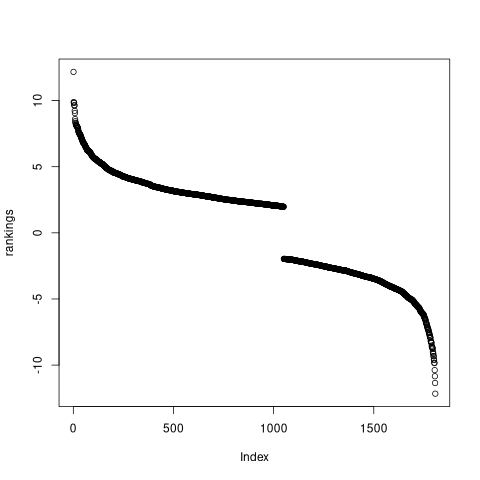

In [21]:
%%R

plot(rankings)

In [22]:
%%R

max(rankings)

[1] 12.16419


In [23]:
%%R

min(rankings)

[1] -12.16139


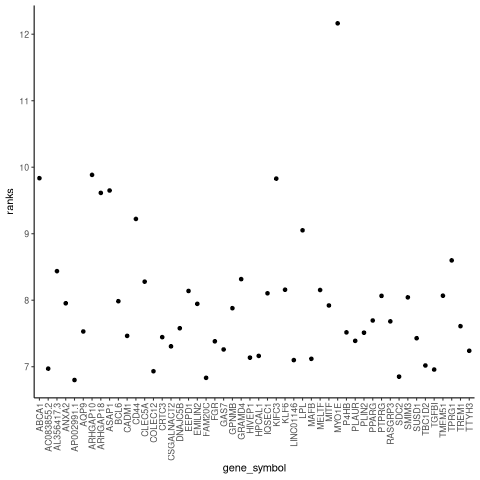

In [24]:
%%R

ggplot(data.frame(gene_symbol = names(rankings)[1:50], ranks = rankings[1:50]), aes(gene_symbol, ranks)) + 
    geom_point() +
    theme_classic() + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [25]:
%%R

head(rankings)

    MYO1E  ARHGAP10     ABCA1     KIFC3     ASAP1  ARHGAP18 
12.164189  9.885121  9.835108  9.828613  9.649745  9.613760 


## START GSEA

In [26]:
%%R
fgsea_OPC <- fgsea(pathways = pathwaysH, 
                  stats    = rankings,
                  scoreType = 'std',
                  minSize  = 15,
                  maxSize  = 500)

In [27]:
%%R
fgsea_OPC

                                       pathway         pval         padj
                                        <char>        <num>        <num>
 1:                      HALLMARK_ADIPOGENESIS 8.355117e-03 0.0297070839
 2:               HALLMARK_ALLOGRAFT_REJECTION 3.270677e-01 0.5162633359
 3:                 HALLMARK_ANDROGEN_RESPONSE 7.904968e-01 0.8159966558
 4:                   HALLMARK_APICAL_JUNCTION 3.583181e-01 0.5181766659
 5:                         HALLMARK_APOPTOSIS 2.089114e-02 0.0668516355
 6:              HALLMARK_BILE_ACID_METABOLISM 4.337121e-01 0.5578818737
 7:           HALLMARK_CHOLESTEROL_HOMEOSTASIS 4.396134e-04 0.0035169069
 8:                        HALLMARK_COMPLEMENT 5.387387e-01 0.6338329764
 9:                       HALLMARK_E2F_TARGETS 1.645570e-01 0.2925457103
10: HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 7.772356e-04 0.0049743077
11:           HALLMARK_ESTROGEN_RESPONSE_EARLY 4.358452e-01 0.5578818737
12:            HALLMARK_ESTROGEN_RESPONSE_LATE 3.72

In [28]:
%%R

dim(fgsea_OPC)

[1] 32  8


In [29]:
%%R
library(data.table)

fwrite(fgsea_OPC, file = "./files/fgsea_MG_DvA_logFC_cutoff.csv")

data.table 1.16.4 using 8 threads (see ?getDTthreads).  Latest news: r-datatable.com

Attaching package: ‘data.table’

The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose



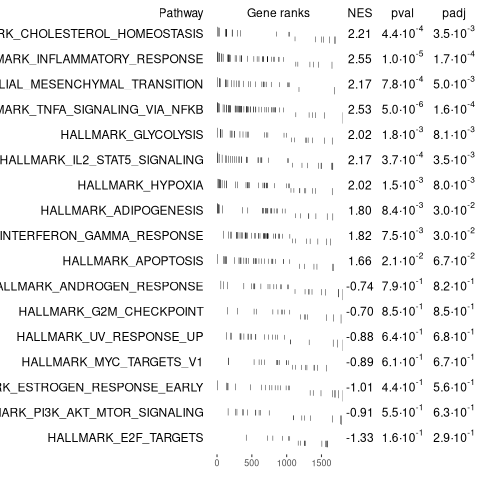

In [30]:
%%R

topUp <- fgsea_OPC %>% 
    filter(ES > 0) %>% 
    top_n(10, wt=-padj)
topDown <- fgsea_OPC %>% 
    filter(ES < 0) %>% 
    top_n(10, wt=-padj)
topPathways <- bind_rows(topUp, topDown) %>% 
    arrange(-ES)
plotGseaTable(pathwaysH[topPathways$pathway], 
              rankings, 
              fgsea_OPC, 
              gseaParam = 0.5)

In [35]:
%%R

# Filter for significant results with padj < 0.05
fgsea_OPC_significant <- fgsea_OPC %>% filter(padj < 0.1)
dim(fgsea_OPC_significant)

[1] 11  8


In [36]:
%%R

head(fgsea_OPC_significant)

                                      pathway         pval        padj
                                       <char>        <num>       <num>
1:                      HALLMARK_ADIPOGENESIS 0.0083551173 0.029707084
2:                         HALLMARK_APOPTOSIS 0.0208911361 0.066851635
3:           HALLMARK_CHOLESTEROL_HOMEOSTASIS 0.0004396134 0.003516907
4: HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 0.0007772356 0.004974308
5:                        HALLMARK_GLYCOLYSIS 0.0017704824 0.008093634
6:                           HALLMARK_HYPOXIA 0.0014946034 0.007971218
     log2err        ES      NES  size
       <num>     <num>    <num> <int>
1: 0.3807304 0.3771861 1.801784    30
2: 0.3524879 0.3296707 1.656269    35
3: 0.4984931 0.5260722 2.208436    21
4: 0.4772708 0.4616107 2.173398    29
5: 0.4550599 0.4348243 2.015042    28
6: 0.4550599 0.3933691 2.015339    37
                                  leadingEdge
                                       <list>
1:            ABCA1,LPL,BCL6,PPARG,P

## Explore specific gene lists?

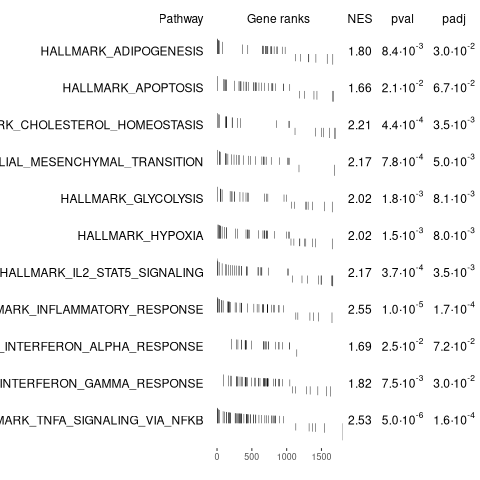

In [37]:
%%R

plotGseaTable(pathwaysH[fgsea_OPC_significant$pathway], 
              rankings, 
              fgsea_OPC_significant, 
              gseaParam = 0.5)

In [38]:
%%R

collapsedPathways <- collapsePathways(fgsea_OPC_significant[order(pval)][padj < 0.1], 
                                      pathwaysH, rankings)

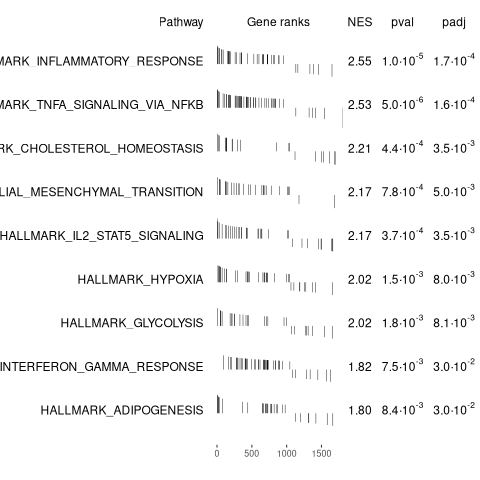

In [39]:
%%R

mainPathways <- fgsea_OPC_significant[pathway %in% collapsedPathways$mainPathways][
                         order(-NES), pathway]
plotGseaTable(pathwaysH[mainPathways], rankings, fgsea_OPC_significant, 
              gseaParam = 0.5)

In [40]:
%%R

fgseaResTidy <- fgsea_OPC %>%
  as_tibble() %>%
  arrange(desc(NES))

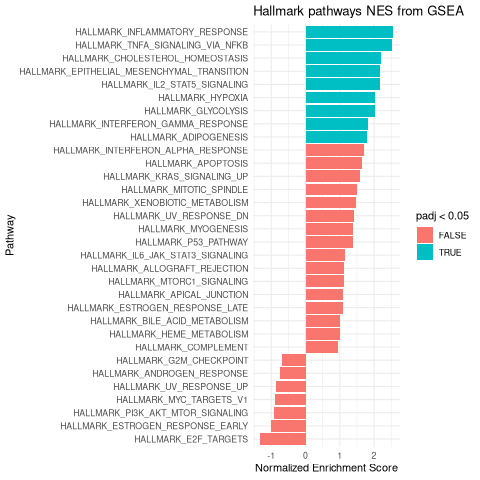

In [41]:
%%R

ggplot(fgseaResTidy, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill=padj<0.05)) +
  coord_flip() +
  labs(x="Pathway", y="Normalized Enrichment Score",
       title="Hallmark pathways NES from GSEA") + 
  theme_minimal()


#https://stephenturner.github.io/deseq-to-fgsea/#using_the_fgsea_package

In [42]:
%%R

# Subset significant results
fgseaResSignificant <- fgseaResTidy[fgseaResTidy$padj < 0.1, ]

# Select columns to display and sort by padj
fgseaResSignificant <- fgseaResSignificant[, c("pathway", "padj", "NES", "size")]
fgseaResSignificant <- fgseaResSignificant[order(fgseaResSignificant$padj), ]

# Print the table
head(fgseaResSignificant)

# A tibble: 6 × 4
  pathway                                        padj   NES  size
  <chr>                                         <dbl> <dbl> <int>
1 HALLMARK_TNFA_SIGNALING_VIA_NFKB           0.000159  2.53    54
2 HALLMARK_INFLAMMATORY_RESPONSE             0.000168  2.55    40
3 HALLMARK_CHOLESTEROL_HOMEOSTASIS           0.00352   2.21    21
4 HALLMARK_IL2_STAT5_SIGNALING               0.00352   2.17    36
5 HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 0.00497   2.17    29
6 HALLMARK_HYPOXIA                           0.00797   2.02    37


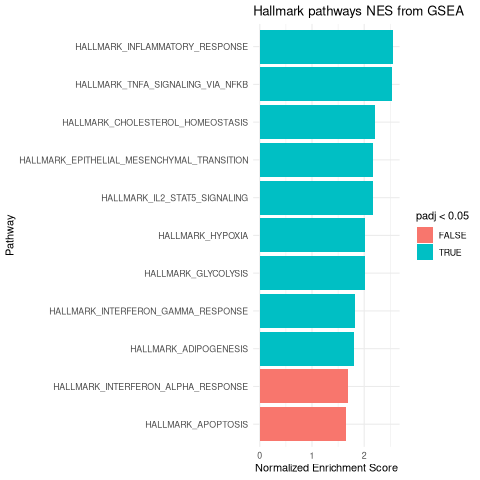

In [43]:
%%R

ggplot(fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill=padj<0.05)) +
  coord_flip() +
  labs(x="Pathway", y="Normalized Enrichment Score",
       title="Hallmark pathways NES from GSEA") + 
  theme_minimal()

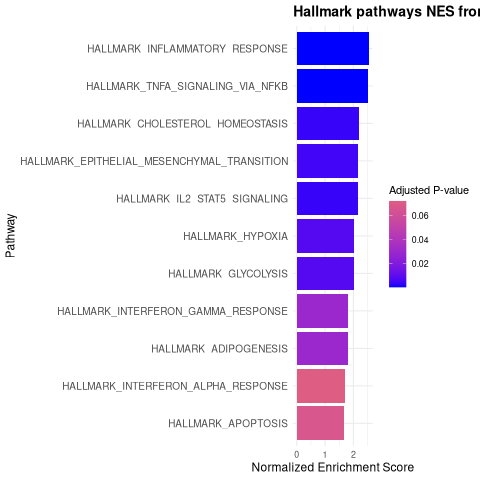

In [44]:
%%R

# Create the ggplot with a color scale for padj
ggplot(fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

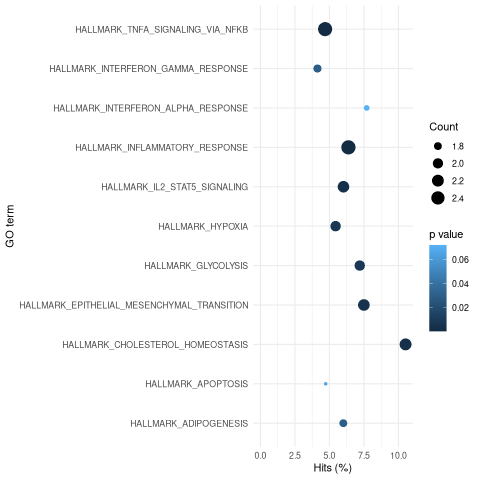

In [45]:
%%R

# Calculate hits percentage (if 'numDEInCat' and 'numInCat' equivalent are 'NES' and 'size')
fgseaResSignificant <- fgseaResSignificant %>%
  mutate(hitsPerc = NES * 100 / size)

# Ensure the columns 'padj' and 'NES' are present for the plot
fgseaResSignificant <- fgseaResSignificant %>%
  rename(term = pathway, over_represented_pvalue = padj, numDEInCat = NES)

# Create the plot
ggplot(fgseaResSignificant, aes(x = hitsPerc, y = term, colour = over_represented_pvalue, size = numDEInCat)) +
  geom_point() +
  expand_limits(x = 0) +
  labs(x = "Hits (%)", y = "GO term", colour = "p value", size = "Count") +
  theme_minimal()

#https://bioinformatics-core-shared-training.github.io/cruk-summer-school-2018/RNASeq2018/html/06_Gene_set_testing.nb.html

In [46]:
%%R

fgsea_OPC_significant

Index: <pathway>
                                       pathway         pval         padj
                                        <char>        <num>        <num>
 1:                      HALLMARK_ADIPOGENESIS 8.355117e-03 0.0297070839
 2:                         HALLMARK_APOPTOSIS 2.089114e-02 0.0668516355
 3:           HALLMARK_CHOLESTEROL_HOMEOSTASIS 4.396134e-04 0.0035169069
 4: HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 7.772356e-04 0.0049743077
 5:                        HALLMARK_GLYCOLYSIS 1.770482e-03 0.0080936338
 6:                           HALLMARK_HYPOXIA 1.494603e-03 0.0079712183
 7:               HALLMARK_IL2_STAT5_SIGNALING 3.714889e-04 0.0035169069
 8:             HALLMARK_INFLAMMATORY_RESPONSE 1.047148e-05 0.0001675436
 9:         HALLMARK_INTERFERON_ALPHA_RESPONSE 2.474163e-02 0.0719756617
10:         HALLMARK_INTERFERON_GAMMA_RESPONSE 7.510124e-03 0.0297070839
11:           HALLMARK_TNFA_SIGNALING_VIA_NFKB 4.975075e-06 0.0001592024
      log2err        ES      NES  

In [47]:
%%R

collapsedPathways <- collapsePathways(fgsea_OPC_significant[order(pval)][padj < 0.05], 
                                      pathwaysH, rankings)

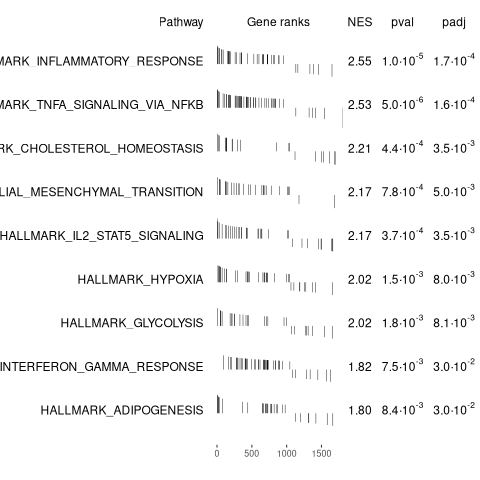

In [48]:
%%R

mainPathways <- fgsea_OPC_significant[pathway %in% collapsedPathways$mainPathways][
                         order(-NES), pathway]
plotGseaTable(pathwaysH[mainPathways], rankings, fgsea_OPC_significant, 
              gseaParam = 0.5)

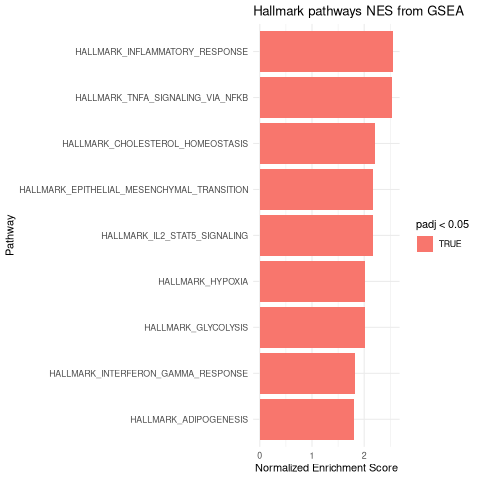

In [49]:
%%R

# Filter fgseaResSignificant to include only the main pathways from collapsedPathways
filtered_fgsea_OPC_significant <- fgsea_OPC_significant %>%
  filter(pathway %in% collapsedPathways$mainPathways)

# Create the ggplot
ggplot(filtered_fgsea_OPC_significant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj < 0.05)) +
  coord_flip() +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal()

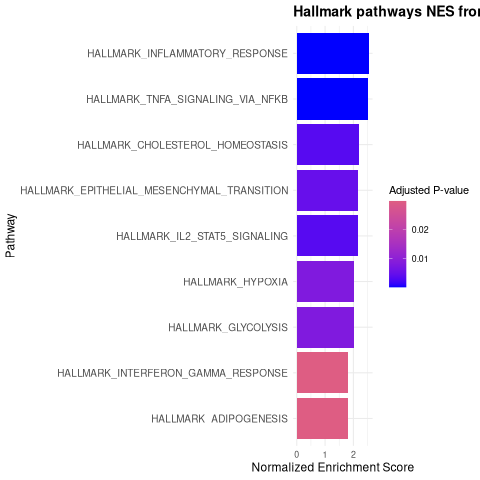

In [50]:
%%R

# Filter fgseaResSignificant to include only the main pathways from collapsedPathways
filtered_fgsea_OPC_significant <- fgsea_OPC_significant %>%
  filter(pathway %in% collapsedPathways$mainPathways)

# Create the ggplot with a color scale for padj
ggplot(filtered_fgsea_OPC_significant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

In [51]:
%%R

# Remove "HALLMARK_" prefix from the 'pathway' column
filtered_fgsea_OPC_significant$pathway <- gsub("^HALLMARK_", "", filtered_fgsea_OPC_significant$pathway)

# View the updated heatmap_df
head(filtered_fgsea_OPC_significant)

                             pathway         pval        padj   log2err
                              <char>        <num>       <num>     <num>
1:                      ADIPOGENESIS 0.0083551173 0.029707084 0.3807304
2:           CHOLESTEROL_HOMEOSTASIS 0.0004396134 0.003516907 0.4984931
3: EPITHELIAL_MESENCHYMAL_TRANSITION 0.0007772356 0.004974308 0.4772708
4:                        GLYCOLYSIS 0.0017704824 0.008093634 0.4550599
5:                           HYPOXIA 0.0014946034 0.007971218 0.4550599
6:               IL2_STAT5_SIGNALING 0.0003714889 0.003516907 0.4984931
          ES      NES  size                               leadingEdge
       <num>    <num> <int>                                    <list>
1: 0.3771861 1.801784    30           ABCA1,LPL,BCL6,PPARG,PLIN2,PIM3
2: 0.5260722 2.208436    21 LPL,PPARG,PLAUR,TNFRSF12A,LGALS3,ATF3,...
3: 0.4616107 2.173398    29 CD44,CADM1,PLAUR,TGFBI,TNFRSF12A,SPP1,...
4: 0.4348243 2.015042    28   CD44,TGFBI,SDC2,MERTK,RRAGD,SLC16A3,...
5: 0

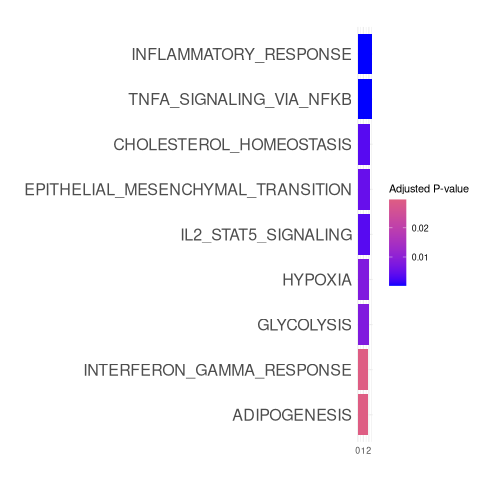

In [52]:
%%R

# Create the ggplot
plot <- ggplot(filtered_fgsea_OPC_significant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "", y = "",
       title = "") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 16),
    axis.title = element_text(size = 16),
    plot.title = element_text(size = 16, face = "bold")
  )

# Save the plot as a high-resolution PNG file
ggsave("./figures/GSEA/AL_Mg_DvA_reduced_hallmark_pathways_NES_GSEA.png", plot = plot, dpi = 300, width = 10, height = 8)

print(plot)

In [53]:
%%R

class(filtered_fgsea_OPC_significant)

[1] "data.table" "data.frame"


In [54]:
%%R

filtered_fgsea_OPC_significant <- as.data.frame(filtered_fgsea_OPC_significant)

In [55]:
%%R
library(data.table)
fwrite(filtered_fgsea_OPC_significant, file = "./files/filtered_fgsea_AL_Mg_DvA_significant.csv")

In [62]:
%%R
unique(filtered_fgsea_OPC_significant$pathway)

[1] "ADIPOGENESIS"                      "CHOLESTEROL_HOMEOSTASIS"          
[3] "EPITHELIAL_MESENCHYMAL_TRANSITION" "GLYCOLYSIS"                       
[5] "HYPOXIA"                           "IL2_STAT5_SIGNALING"              
[7] "INFLAMMATORY_RESPONSE"             "INTERFERON_GAMMA_RESPONSE"        
[9] "TNFA_SIGNALING_VIA_NFKB"          


In [63]:
%%R

# Define the pathway of interest
pathway_of_interest <- "CHOLESTEROL_HOMEOSTASIS"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgsea_OPC_significant[filtered_fgsea_OPC_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "LPL"       "PPARG"     "PLAUR"     "TNFRSF12A" "LGALS3"    "ATF3"     
 [7] "FABP5"     "NFIL3"     "CD9"       "ALCAM"     "ATF5"      "LGMN"     


In [64]:
%%R
# Filter genes_down_sorted for genes in leading_edge_genes
matching_genes <- genes_up_sorted[genes_up_sorted$gene %in% leading_edge_genes, ]

# Print the filtered data frame
print(matching_genes)

# Optionally, count the number of matching genes
num_matching_genes <- nrow(matching_genes)
cat("Number of matching genes found:", num_matching_genes, "\n")

         gene    logFC  AveExpr          t      P.Value    adj.P.Val          B
20        LPL 6.305634 5.514095 -10.375745 8.875418e-10 4.011689e-07  9.4256579
239     FABP5 4.266962 2.652206  -6.332385 5.062716e-06 1.914935e-04  2.6117443
233    LGALS3 3.580635 3.561162  -6.406490 4.420939e-06 1.715249e-04  3.6321088
236      ATF3 3.400286 3.362754  -6.343557 4.607245e-06 1.764809e-04  2.7907645
69      PLAUR 3.394943 6.594459 -10.069227 4.085907e-08 5.353130e-06 11.8549367
380       CD9 2.824171 5.262772  -6.487771 3.257067e-05 7.734092e-04  4.8388286
55      PPARG 2.529396 8.359265  -9.185352 2.017614e-08 3.316224e-06  5.8325177
522      ATF5 2.484150 4.200239  -4.984641 9.010473e-05 1.560434e-03  0.1246735
216 TNFRSF12A 2.343996 2.895767  -6.189182 3.648825e-06 1.526377e-04  4.3748665
385     ALCAM 1.984311 9.868054  -5.777125 3.378827e-05 7.933661e-04  0.5313953
583      LGMN 1.908975 6.596608  -5.148866 1.328444e-04 2.059886e-03  1.3533739
242     NFIL3 1.749786 4.193729  -6.0109

In [65]:
%%R

# Define the pathway of interest
pathway_of_interest <- "INTERFERON_GAMMA_RESPONSE"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgsea_OPC_significant[filtered_fgsea_OPC_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "ARID5B"  "LCP2"    "ICAM1"   "HELZ2"   "BST2"    "SOCS3"   "VAMP8"  
 [8] "PARP12"  "GCH1"    "CXCL10"  "OAS2"    "IFI27"   "IFI35"   "ISG20"  
[15] "MX1"     "CCL2"    "ISG15"   "MX2"     "SPPL2A"  "UPP1"    "PIM1"   
[22] "ST3GAL5" "IRF7"    "CASP7"   "TNFAIP3" "IFIT3"   "UBE2L6"  "IFIH1"  
[29] "TAPBP"   "IFITM3" 


In [66]:
%%R
# Filter genes_down_sorted for genes in leading_edge_genes
matching_genes <- genes_up_sorted[genes_up_sorted$gene %in% leading_edge_genes, ]

# Print the filtered data frame
print(matching_genes)

# Optionally, count the number of matching genes
num_matching_genes <- nrow(matching_genes)
cat("Number of matching genes found:", num_matching_genes, "\n")

        gene     logFC  AveExpr         t      P.Value    adj.P.Val           B
609   CXCL10 3.4557872 1.668390 -4.658097 1.633209e-04 2.424337e-03 -0.54898391
363    HELZ2 3.2869211 2.227904 -5.440657 2.761017e-05 6.859628e-04  1.23551791
769     CCL2 3.2674783 1.800189 -4.287530 4.235800e-04 4.979406e-03 -0.28014160
171   ARID5B 3.2492856 7.233335 -9.844136 1.502506e-06 7.943074e-05  4.10649468
886    ISG15 3.1789641 3.086564 -4.086826 6.816266e-04 6.954746e-03 -0.81806020
500    SOCS3 2.6796829 1.660045 -5.006959 8.036012e-05 1.452911e-03  1.28327055
1220   IFIT3 2.6657933 3.921813 -3.616902 1.949130e-03 1.444273e-02 -1.91313314
734    ISG20 2.6650412 2.063000 -4.383448 3.523442e-04 4.339498e-03 -0.19419867
709    IFI27 2.6585369 1.869465 -4.399512 3.194056e-04 4.072535e-03 -0.57492986
965      MX2 2.2846325 6.420069 -4.296512 9.074356e-04 8.500744e-03 -0.45783858
636     OAS2 2.2134396 4.378287 -4.491167 1.954039e-04 2.777440e-03  0.39588263
743      MX1 2.1835701 6.412452 -4.22521

In [67]:
%%R

# Define the pathway of interest
pathway_of_interest <- "TNFA_SIGNALING_VIA_NFKB"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgsea_OPC_significant[filtered_fgsea_OPC_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "ABCA1"   "CD44"    "KLF6"    "BCL6"    "PLAUR"   "NR4A3"   "LITAF"  
 [8] "ATF3"    "NFIL3"   "IFNGR2"  "HBEGF"   "PTGER4"  "BCL2A1"  "ICAM1"  
[15] "SPHK1"   "MAP2K3"  "SOCS3"   "FOSL2"   "EGR1"    "GADD45B" "B4GALT5"
[22] "GCH1"    "BTG3"    "CSF1"    "CXCL10"  "NR4A1"   "CCL4"    "EGR2"   
[29] "CCL2"    "VEGFA"   "PANX1"   "KLF10"   "PDLIM5"  "TGIF1"  


In [68]:
%%R
# Filter genes_down_sorted for genes in leading_edge_genes
matching_genes <- genes_up_sorted[genes_up_sorted$gene %in% leading_edge_genes, ]

# Print the filtered data frame
print(matching_genes)

# Optionally, count the number of matching genes
num_matching_genes <- nrow(matching_genes)
cat("Number of matching genes found:", num_matching_genes, "\n")

       gene     logFC  AveExpr          t      P.Value    adj.P.Val           B
17     CD44 4.6117624 4.743871 -10.602523 5.992990e-10 3.186860e-07 12.94510669
158   NR4A3 4.3013796 2.869895  -7.057578 1.017812e-06 5.823430e-05  4.21989507
339  BCL2A1 4.1147494 2.979350  -5.666280 2.008590e-05 5.356240e-04  1.17788903
745    CCL4 3.9460806 2.235107  -4.343476 3.737146e-04 4.534738e-03 -1.49740012
311   HBEGF 3.9105111 2.552004  -6.003539 1.509804e-05 4.388625e-04  1.76909841
550 GADD45B 3.7547855 2.860601  -5.028188 1.099340e-04 1.805158e-03 -0.25178816
609  CXCL10 3.4557872 1.668390  -4.658097 1.633209e-04 2.424337e-03 -0.54898391
236    ATF3 3.4002863 3.362754  -6.343557 4.607245e-06 1.764809e-04  2.79076448
69    PLAUR 3.3949432 6.594459 -10.069227 4.085907e-08 5.353130e-06 11.85493670
606    CSF1 3.3591462 2.594255  -4.580762 1.575817e-04 2.350723e-03  0.65036991
513   FOSL2 3.3050543 2.546886  -5.055245 8.828800e-05 1.553989e-03  1.21547376
769    CCL2 3.2674783 1.800189  -4.28753

In [69]:
%%R

# Define the pathway of interest
pathway_of_interest <- "INFLAMMATORY_RESPONSE"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgsea_OPC_significant[filtered_fgsea_OPC_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "ABCA1"   "CLEC5A"  "KLF6"    "AQP9"    "PLAUR"   "HRH1"    "C5AR1"  
 [8] "SLC31A1" "SLC7A1"  "LCP2"    "IFNGR2"  "HBEGF"   "PTGER4"  "ICAM1"  
[15] "SPHK1"   "BST2"    "GCH1"    "NOD2"    "CSF1"    "CXCL10" 


In [70]:
%%R
# Filter genes_down_sorted for genes in leading_edge_genes
matching_genes <- genes_up_sorted[genes_up_sorted$gene %in% leading_edge_genes, ]

# Print the filtered data frame
print(matching_genes)

# Optionally, count the number of matching genes
num_matching_genes <- nrow(matching_genes)
cat("Number of matching genes found:", num_matching_genes, "\n")

       gene    logFC  AveExpr          t      P.Value    adj.P.Val          B
62     AQP9 5.794929 3.017006  -8.800198 2.952546e-08 4.305002e-06  9.2666611
33   CLEC5A 4.347029 4.563973  -9.376086 5.262275e-09 1.441544e-06 10.8546731
311   HBEGF 3.910511 2.552004  -6.003539 1.509804e-05 4.388625e-04  1.7690984
121    HRH1 3.642327 4.614713  -7.686093 4.136139e-07 3.090140e-05  5.9969897
609  CXCL10 3.455787 1.668390  -4.658097 1.633209e-04 2.424337e-03 -0.5489839
69    PLAUR 3.394943 6.594459 -10.069227 4.085907e-08 5.353130e-06 11.8549367
606    CSF1 3.359146 2.594255  -4.580762 1.575817e-04 2.350723e-03  0.6503699
312  PTGER4 2.952036 3.737224  -7.471510 1.518111e-05 4.398629e-04  5.6742041
602    NOD2 2.930274 2.439481  -4.778964 1.522983e-04 2.285240e-03 -0.4745337
8     ABCA1 2.871830 7.456305 -11.455642 1.461815e-10 1.364180e-07 14.3719095
463   SPHK1 2.543621 2.770234  -5.148529 6.215728e-05 1.213611e-03  0.7032519
263  SLC7A1 2.339486 5.188209  -6.270149 7.520933e-06 2.585142e-

# MG_E

In [72]:
%%R

# Replace the file path with the actual path if the file is not in the current directory
df <- read.csv("./files/MG_EvA_WM_v_AL_dream.csv")
head(df)  # Display the first few rows of the data frame to confirm it's loaded correctly

        gene     logFC  AveExpr         t      P.Value    adj.P.Val        B
1 ST6GALNAC3  3.607608 9.301374  14.95492 1.839725e-13 1.636803e-09 20.84642
2       MITF -2.584601 8.405525 -14.12286 6.169291e-13 1.640748e-09 19.67965
3    TMEM156  2.251460 7.480863  14.02233 7.168029e-13 1.640748e-09 19.53083
4      ABCC4  2.225773 9.108282  13.78360 1.027183e-12 1.640748e-09 19.19841
5   SERPINB9  3.628969 6.308778  14.09847 1.046810e-12 1.640748e-09 14.11308
6   ARHGAP10 -5.802836 4.580765 -13.73465 1.106495e-12 1.640748e-09 18.29881
      z.std     gene.1
1  7.359955 ST6GALNAC3
2 -7.196688       MITF
3  7.176191    TMEM156
4  7.126815      ABCC4
5  7.124208   SERPINB9
6 -7.116566   ARHGAP10


In [73]:
%%R

# Assign names to the rankings
df$logFC <- df$logFC * -1

In [74]:
%%R

# Define the gene of interest
gene_of_interest <- "SPP1"  # Replace with the gene you want to search for

# Filter the data frame to find the row corresponding to the gene
gene_row <- df[df$gene == gene_of_interest, ]

# Print the row corresponding to the gene
if (nrow(gene_row) > 0) {
  print("Details for the gene of interest:")
  print(gene_row)
} else {
  cat("Gene", gene_of_interest, "not found in the data frame.\n")
}

[1] "Details for the gene of interest:"
     gene      logFC  AveExpr        t    P.Value  adj.P.Val         B    z.std
2518 SPP1 -0.7562094 10.33845 2.437642 0.02602282 0.09194798 -4.222763 2.225871
     gene.1
2518   SPP1


In [75]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_up <- df[df$adj.P.Val < 0.05 & df$logFC > 0.585, ]
num_genes_up <- nrow(genes_up)

# Print the number of significant genes
print(num_genes_up)

genes_up_sorted <- genes_up[order(genes_up$logFC, decreasing = TRUE), ]

# View the head of the significant genes data frame
head(genes_up_sorted)

[1] 932
           gene    logFC  AveExpr          t      P.Value    adj.P.Val
1422     HS3ST2 6.976411 3.542495  -3.265752 3.350897e-03 2.096549e-02
94        TRHDE 6.810385 3.891787  -7.823502 5.926735e-08 5.581814e-06
42   AP002991.1 6.778642 4.184528 -10.113319 3.026139e-09 6.360449e-07
8          EYA2 6.773520 5.108346 -12.561164 7.125343e-12 7.046165e-09
712     GALNTL6 6.520834 3.690007  -4.341844 2.328273e-04 2.909360e-03
25        NUPR1 6.517721 5.758526 -10.176100 4.626173e-10 1.646362e-07
              B     z.std     gene.1
1422 -2.0972382 -2.933568     HS3ST2
94    5.5431862 -5.420998      TRHDE
42   10.9220327 -5.930174 AP002991.1
8     8.8594225 -6.855118       EYA2
712   0.4865968 -3.680445    GALNTL6
25    8.1490091 -6.231287      NUPR1


In [76]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_down <- df[df$adj.P.Val < 0.05 & df$logFC < -0.585, ]
num_genes_down <- nrow(genes_down)

# Print the number of significant genes
print(num_genes_down)

genes_down_sorted <- genes_down[order(genes_down$logFC, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_down_sorted)

[1] 817
          gene     logFC  AveExpr         t      P.Value    adj.P.Val         B
7   AP003481.1 -6.079328 5.573891 14.134498 1.850247e-12 2.351663e-09 12.641618
55       HCG22 -5.124495 3.824271  8.780022 9.498348e-09 1.536487e-06  4.935034
151 AC008691.1 -4.740215 7.592862  7.800899 4.094379e-07 2.412430e-05  1.467827
10      CLEC9A -4.668491 3.679229 12.491908 8.264556e-12 7.046165e-09  8.803198
33      PTPN14 -4.390247 5.287845  9.511388 1.669984e-09 4.467259e-07 11.918043
112       ACY3 -4.375452 3.281905  7.789384 1.296662e-07 1.030036e-05  2.627692
       z.std     gene.1
7   7.045328 AP003481.1
55  5.739452      HCG22
151 5.064517 AC008691.1
10  6.833885     CLEC9A
33  6.027032     PTPN14
112 5.279317       ACY3


In [77]:
%%R

dim(df)

[1] 8897    9


In [78]:
%%R

my_genes <- df$gene
head(my_genes)

[1] "ST6GALNAC3" "MITF"       "TMEM156"    "ABCC4"      "SERPINB9"  
[6] "ARHGAP10"  


In [79]:
%%R
# Check column names in the dataframe
colnames(df)

[1] "gene"      "logFC"     "AveExpr"   "t"         "P.Value"   "adj.P.Val"
[7] "B"         "z.std"     "gene.1"   


In [80]:
%%R

# Filter the dataset for significant genes
filtered_df <- df[abs(df$logFC) >= 0.585 & df$adj.P.Val < 0.05, ]

# Compute ranking score: sign(logFC) * -log10(P.Value)
filtered_df$ranking_score <- sign(filtered_df$logFC) * -log10(filtered_df$P.Value)

# Assign names to the rankings
rankings <- filtered_df$ranking_score
names(rankings) <- filtered_df$gene

# Sort the rankings in descending order
rankings <- sort(rankings, decreasing = TRUE)

In [81]:
%%R

length(rankings)

[1] 1749


In [82]:
%%R

# Ensure the length of the gene column matches the length of rankings
length(df$gene) == length(rankings)

[1] FALSE


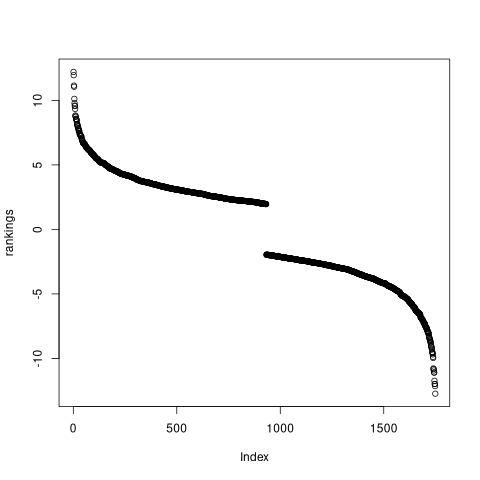

In [83]:
%%R

plot(rankings)

In [84]:
%%R

max(rankings)

[1] 12.20976


In [85]:
%%R

min(rankings)

[1] -12.73525


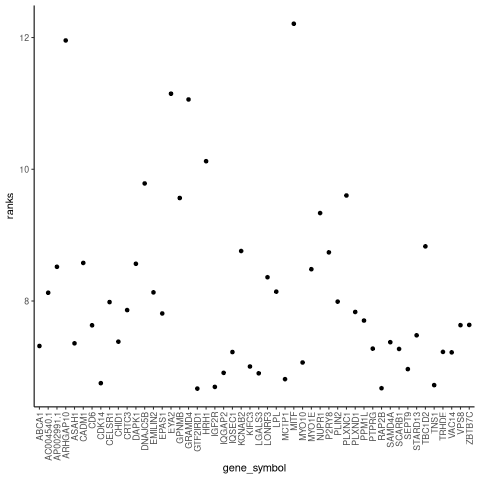

In [86]:
%%R

ggplot(data.frame(gene_symbol = names(rankings)[1:50], ranks = rankings[1:50]), aes(gene_symbol, ranks)) + 
    geom_point() +
    theme_classic() + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [87]:
%%R

head(rankings)

     MITF  ARHGAP10      EYA2    GRAMD4      HRH1   DNAJC5B 
12.209765 11.956050 11.147194 11.059898 10.122382  9.784858 


## START GSEA

In [88]:
%%R
fgsea_OPC <- fgsea(pathways = pathwaysH, 
                  stats    = rankings,
                  scoreType = 'std',
                  minSize  = 15,
                  maxSize  = 500)

In [89]:
%%R
fgsea_OPC

                                       pathway        pval       padj
                                        <char>       <num>      <num>
 1:                      HALLMARK_ADIPOGENESIS 0.091666667 0.68263473
 2:               HALLMARK_ALLOGRAFT_REJECTION 0.741088180 0.96097202
 3:                 HALLMARK_ANDROGEN_RESPONSE 0.758349705 0.96097202
 4:                   HALLMARK_APICAL_JUNCTION 0.893410853 0.96097202
 5:                         HALLMARK_APOPTOSIS 0.402321083 0.86211661
 6:              HALLMARK_BILE_ACID_METABOLISM 0.983436853 0.98343685
 7:           HALLMARK_CHOLESTEROL_HOMEOSTASIS 0.113772455 0.68263473
 8:                        HALLMARK_COMPLEMENT 0.892045455 0.96097202
 9: HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 0.002813644 0.08440932
10:           HALLMARK_ESTROGEN_RESPONSE_EARLY 0.263157895 0.79703597
11:            HALLMARK_ESTROGEN_RESPONSE_LATE 0.397938144 0.86211661
12:             HALLMARK_FATTY_ACID_METABOLISM 0.277890467 0.79703597
13:                 

In [90]:
%%R

dim(fgsea_OPC)

[1] 30  8


In [91]:
%%R
library(data.table)

fwrite(fgsea_OPC, file = "./files/fgsea_MG_EvA_full.csv")

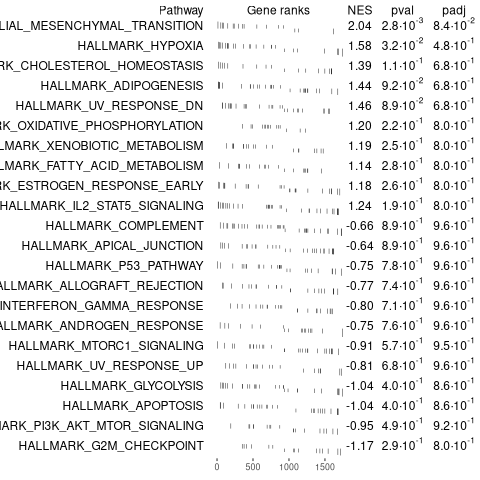

In [92]:
%%R

topUp <- fgsea_OPC %>% 
    filter(ES > 0) %>% 
    top_n(10, wt=-padj)
topDown <- fgsea_OPC %>% 
    filter(ES < 0) %>% 
    top_n(10, wt=-padj)
topPathways <- bind_rows(topUp, topDown) %>% 
    arrange(-ES)
plotGseaTable(pathwaysH[topPathways$pathway], 
              rankings, 
              fgsea_OPC, 
              gseaParam = 0.5)

In [93]:
%%R

# Filter for significant results with padj < 0.05
fgsea_OPC_significant <- fgsea_OPC %>% filter(padj < 0.1)
dim(fgsea_OPC_significant)

[1] 1 8


In [94]:
%%R

head(fgsea_OPC_significant)

                                      pathway        pval       padj   log2err
                                       <char>       <num>      <num>     <num>
1: HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 0.002813644 0.08440932 0.4317077
          ES      NES  size                          leadingEdge
       <num>    <num> <int>                               <list>
1: 0.5131892 2.038568    17 CADM1,TGFBI,PMP22,CD44,PLAUR,VIM,...


## Explore specific gene lists?

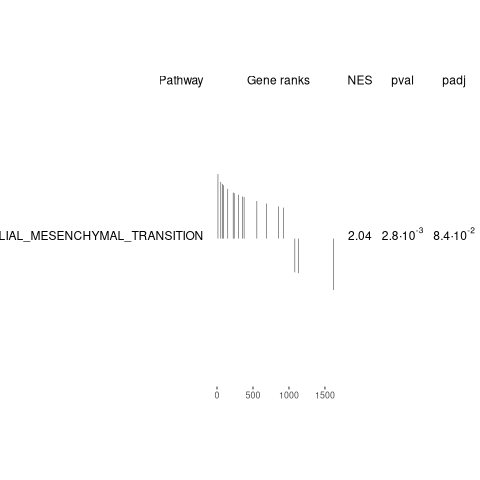

In [95]:
%%R

plotGseaTable(pathwaysH[fgsea_OPC_significant$pathway], 
              rankings, 
              fgsea_OPC_significant, 
              gseaParam = 0.5)

In [96]:
%%R

collapsedPathways <- collapsePathways(fgsea_OPC_significant[order(pval)][padj < 0.1], 
                                      pathwaysH, rankings)

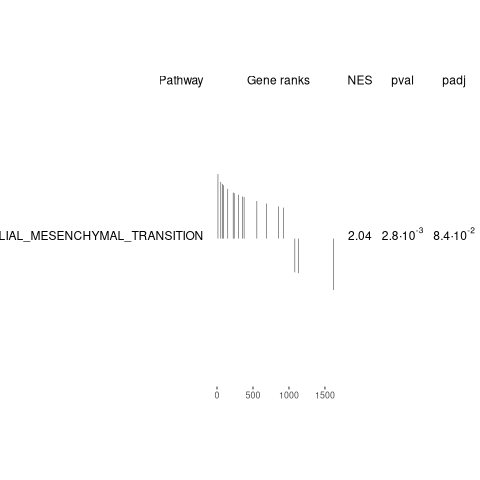

In [97]:
%%R

mainPathways <- fgsea_OPC_significant[pathway %in% collapsedPathways$mainPathways][
                         order(-NES), pathway]
plotGseaTable(pathwaysH[mainPathways], rankings, fgsea_OPC_significant, 
              gseaParam = 0.5)

In [98]:
%%R

fgseaResTidy <- fgsea_OPC %>%
  as_tibble() %>%
  arrange(desc(NES))

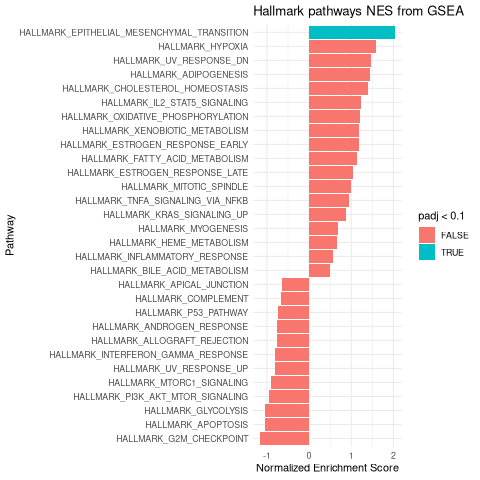

In [99]:
%%R

ggplot(fgseaResTidy, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill=padj<0.1)) +
  coord_flip() +
  labs(x="Pathway", y="Normalized Enrichment Score",
       title="Hallmark pathways NES from GSEA") + 
  theme_minimal()


#https://stephenturner.github.io/deseq-to-fgsea/#using_the_fgsea_package

In [100]:
%%R

# Subset significant results
fgseaResSignificant <- fgseaResTidy[fgseaResTidy$padj < 0.1, ]

# Select columns to display and sort by padj
fgseaResSignificant <- fgseaResSignificant[, c("pathway", "padj", "NES", "size")]
fgseaResSignificant <- fgseaResSignificant[order(fgseaResSignificant$padj), ]

# Print the table
head(fgseaResSignificant)

# A tibble: 1 × 4
  pathway                                      padj   NES  size
  <chr>                                       <dbl> <dbl> <int>
1 HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 0.0844  2.04    17


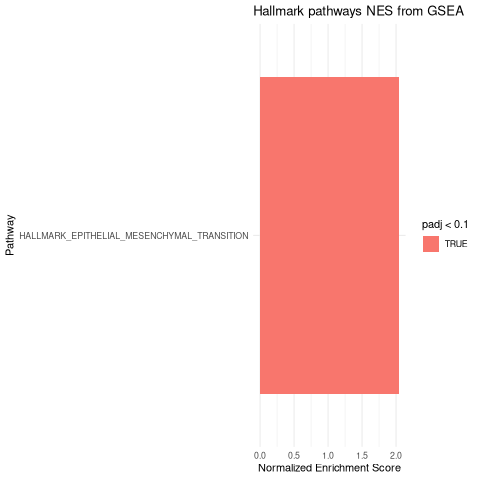

In [101]:
%%R

ggplot(fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill=padj<0.1)) +
  coord_flip() +
  labs(x="Pathway", y="Normalized Enrichment Score",
       title="Hallmark pathways NES from GSEA") + 
  theme_minimal()

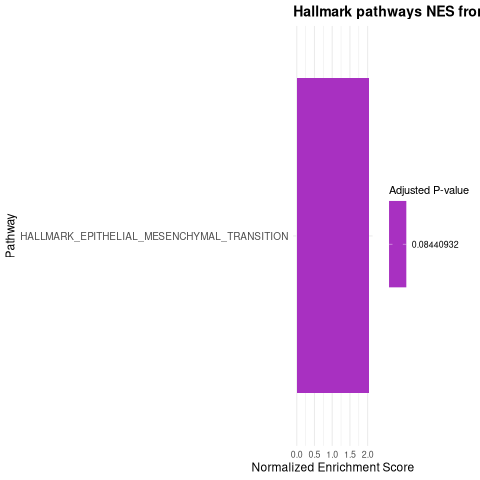

In [102]:
%%R

# Create the ggplot with a color scale for padj
ggplot(fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

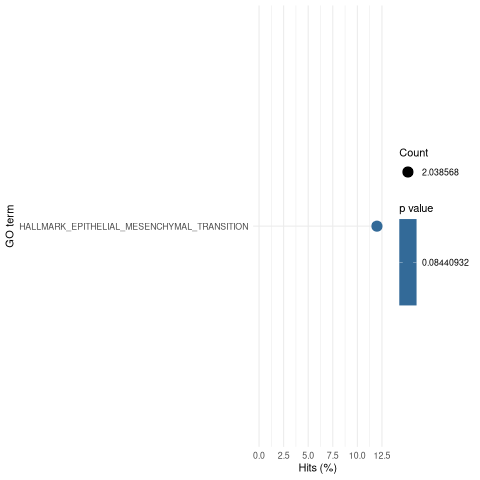

In [103]:
%%R

# Calculate hits percentage (if 'numDEInCat' and 'numInCat' equivalent are 'NES' and 'size')
fgseaResSignificant <- fgseaResSignificant %>%
  mutate(hitsPerc = NES * 100 / size)

# Ensure the columns 'padj' and 'NES' are present for the plot
fgseaResSignificant <- fgseaResSignificant %>%
  rename(term = pathway, over_represented_pvalue = padj, numDEInCat = NES)

# Create the plot
ggplot(fgseaResSignificant, aes(x = hitsPerc, y = term, colour = over_represented_pvalue, size = numDEInCat)) +
  geom_point() +
  expand_limits(x = 0) +
  labs(x = "Hits (%)", y = "GO term", colour = "p value", size = "Count") +
  theme_minimal()

#https://bioinformatics-core-shared-training.github.io/cruk-summer-school-2018/RNASeq2018/html/06_Gene_set_testing.nb.html

In [104]:
%%R

fgsea_OPC_significant

Index: <pathway>
                                      pathway        pval       padj   log2err
                                       <char>       <num>      <num>     <num>
1: HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 0.002813644 0.08440932 0.4317077
          ES      NES  size                          leadingEdge
       <num>    <num> <int>                               <list>
1: 0.5131892 2.038568    17 CADM1,TGFBI,PMP22,CD44,PLAUR,VIM,...


In [105]:
%%R

collapsedPathways <- collapsePathways(fgsea_OPC_significant[order(pval)][padj < 0.1], 
                                      pathwaysH, rankings)

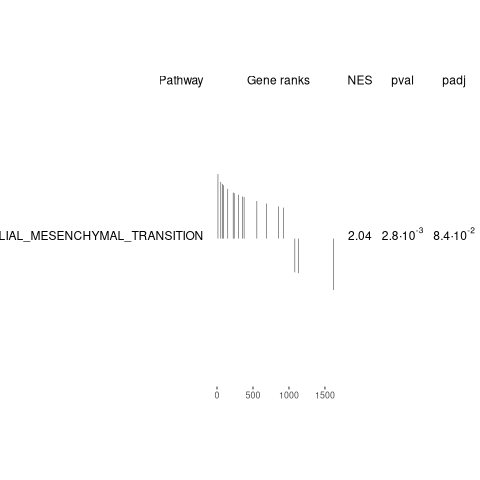

In [106]:
%%R

mainPathways <- fgsea_OPC_significant[pathway %in% collapsedPathways$mainPathways][
                         order(-NES), pathway]
plotGseaTable(pathwaysH[mainPathways], rankings, fgsea_OPC_significant, 
              gseaParam = 0.5)

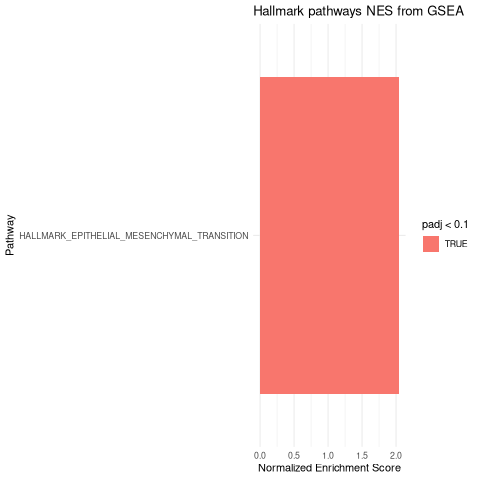

In [107]:
%%R

# Filter fgseaResSignificant to include only the main pathways from collapsedPathways
filtered_fgsea_OPC_significant <- fgsea_OPC_significant %>%
  filter(pathway %in% collapsedPathways$mainPathways)

# Create the ggplot
ggplot(filtered_fgsea_OPC_significant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj < 0.1)) +
  coord_flip() +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal()

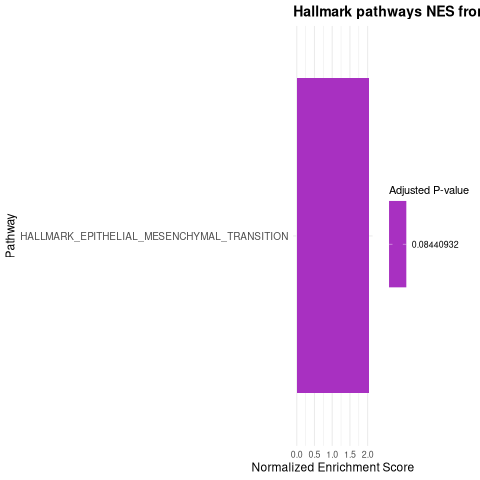

In [108]:
%%R

# Filter fgseaResSignificant to include only the main pathways from collapsedPathways
filtered_fgsea_OPC_significant <- fgsea_OPC_significant %>%
  filter(pathway %in% collapsedPathways$mainPathways)

# Create the ggplot with a color scale for padj
ggplot(filtered_fgsea_OPC_significant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

In [109]:
%%R

# Remove "HALLMARK_" prefix from the 'pathway' column
filtered_fgsea_OPC_significant$pathway <- gsub("^HALLMARK_", "", filtered_fgsea_OPC_significant$pathway)

# View the updated heatmap_df
head(filtered_fgsea_OPC_significant)

                             pathway        pval       padj   log2err        ES
                              <char>       <num>      <num>     <num>     <num>
1: EPITHELIAL_MESENCHYMAL_TRANSITION 0.002813644 0.08440932 0.4317077 0.5131892
        NES  size                          leadingEdge
      <num> <int>                               <list>
1: 2.038568    17 CADM1,TGFBI,PMP22,CD44,PLAUR,VIM,...


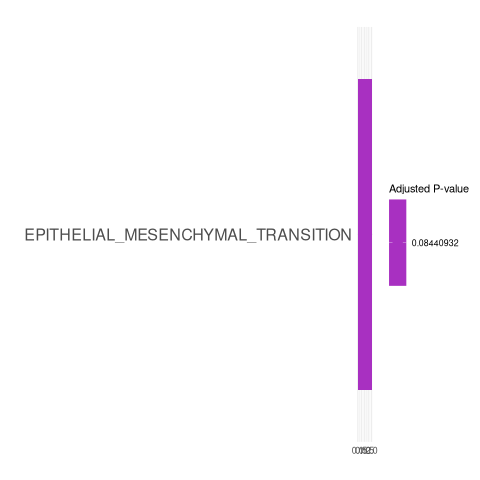

In [110]:
%%R

# Create the ggplot
plot <- ggplot(filtered_fgsea_OPC_significant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "", y = "",
       title = "") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 16),
    axis.title = element_text(size = 16),
    plot.title = element_text(size = 16, face = "bold")
  )

# Save the plot as a high-resolution PNG file
ggsave("./figures/GSEA/AL_Mg_EvA_reduced_hallmark_pathways_NES_GSEA.png", plot = plot, dpi = 300, width = 10, height = 8)

print(plot)

In [111]:
%%R

class(filtered_fgsea_OPC_significant)

[1] "data.table" "data.frame"


In [112]:
%%R

filtered_fgsea_OPC_significant <- as.data.frame(filtered_fgsea_OPC_significant)

In [113]:
%%R
library(data.table)
fwrite(filtered_fgsea_OPC_significant, file = "./files/filtered_fgsea_AL_Mg_EvA_significant.csv")

In [114]:
%%R
unique(filtered_fgsea_OPC_significant$pathway)

[1] "EPITHELIAL_MESENCHYMAL_TRANSITION"


In [115]:
%%R

# Define the pathway of interest
pathway_of_interest <- "EPITHELIAL_MESENCHYMAL_TRANSITION"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgsea_OPC_significant[filtered_fgsea_OPC_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "CADM1"  "TGFBI"  "PMP22"  "CD44"   "PLAUR"  "VIM"    "SNTB1"  "LGALS1"
 [9] "CAPG"   "NOTCH2"


In [116]:
%%R
# Filter genes_down_sorted for genes in leading_edge_genes
matching_genes <- genes_up_sorted[genes_up_sorted$gene %in% leading_edge_genes, ]

# Print the filtered data frame
print(matching_genes)

# Optionally, count the number of matching genes
num_matching_genes <- nrow(matching_genes)
cat("Number of matching genes found:", num_matching_genes, "\n")

      gene    logFC  AveExpr         t      P.Value    adj.P.Val          B
174  PMP22 5.592516 3.383726 -6.909302 6.970587e-07 3.564213e-05  6.4776160
126  TGFBI 4.849621 3.396956 -7.188287 2.413033e-07 1.703869e-05  4.7162679
201   CD44 4.482151 4.790236 -6.454922 1.298682e-06 5.748446e-05  5.4440357
458    VIM 4.018400 4.059010 -5.110181 4.260725e-05 8.276784e-04  1.5526190
586 LGALS1 3.791554 3.988267 -5.000930 1.059059e-04 1.607494e-03 -0.9207659
39   CADM1 3.677030 7.134390 -9.280006 2.644861e-09 6.033675e-07 11.4847954
482  SNTB1 3.176867 3.759542 -5.082506 5.276672e-05 9.725509e-04  0.4835917
312  PLAUR 2.413077 6.099343 -6.104709 7.946661e-06 2.266072e-04  1.2291531
702   CAPG 1.620857 5.915007 -4.542460 2.198095e-04 2.785819e-03 -0.6059083
742 NOTCH2 1.262869 7.213966 -4.476152 2.707492e-04 3.246436e-03 -0.6625959
        z.std gene.1
174 -4.962181  PMP22
126 -5.164329  TGFBI
201 -4.839955   CD44
458 -4.092867    VIM
586 -3.876647 LGALS1
39  -5.952247  CADM1
482 -4.043022  SN

# MG_F

In [117]:
%%R

# Replace the file path with the actual path if the file is not in the current directory
df <- read.csv("./files/MG_FvA_WM_v_RL_dream.csv")
head(df)  # Display the first few rows of the data frame to confirm it's loaded correctly

     gene     logFC  AveExpr         t      P.Value    adj.P.Val         B
1  PLXNC1 -4.977773 4.649426 -16.25569 2.048165e-10 2.082574e-06 14.083097
2 EMILIN2 -4.500667 2.496653 -13.67313 1.970558e-09 8.211570e-06 11.794060
3  PTPN22 -4.157709 3.407846 -13.45659 2.422768e-09 8.211570e-06 11.794833
4 ATP6AP2 -1.921152 5.251481 -14.62884 7.633830e-09 1.940519e-05 12.875851
5   TGFBI -7.448151 3.187120 -12.12547 1.838235e-08 3.441108e-05  3.413571
6 LDLRAD3 -4.129834 3.491407 -11.25580 2.364878e-08 3.441108e-05  9.642147
      z.std  gene.1
1 -6.357685  PLXNC1
2 -6.000215 EMILIN2
3 -5.966581  PTPN22
4 -5.776350 ATP6AP2
5 -5.626574   TGFBI
6 -5.582939 LDLRAD3


In [118]:
%%R

# Assign names to the rankings
df$logFC <- df$logFC * -1

In [119]:
%%R

# Define the gene of interest
gene_of_interest <- "SPP1"  # Replace with the gene you want to search for

# Filter the data frame to find the row corresponding to the gene
gene_row <- df[df$gene == gene_of_interest, ]

# Print the row corresponding to the gene
if (nrow(gene_row) > 0) {
  print("Details for the gene of interest:")
  print(gene_row)
} else {
  cat("Gene", gene_of_interest, "not found in the data frame.\n")
}

[1] "Details for the gene of interest:"
     gene      logFC  AveExpr         t   P.Value adj.P.Val         B    z.std
7827 SPP1 -0.6543986 10.54739 0.4525186 0.6584639 0.8553112 -4.834689 0.442035
     gene.1
7827   SPP1


In [120]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_up <- df[df$adj.P.Val < 0.05 & df$logFC > 0.585, ]
num_genes_up <- nrow(genes_up)

# Print the number of significant genes
print(num_genes_up)

genes_up_sorted <- genes_up[order(genes_up$logFC, decreasing = TRUE), ]

# View the head of the significant genes data frame
head(genes_up_sorted)

[1] 986
        gene     logFC  AveExpr          t      P.Value    adj.P.Val         B
20  SLC16A10 10.285514 2.778463  -8.634169 6.064820e-07 2.792234e-04 6.0885394
99      AREG  8.408036 1.962417  -7.554457 1.088199e-05 1.117657e-03 4.0236909
5      TGFBI  7.448151 3.187120 -12.125474 1.838235e-08 3.441108e-05 3.4135712
157    CD163  7.202863 3.218087  -6.478642 3.689246e-05 2.380161e-03 0.2796263
42       ADM  7.088885 1.591672  -7.792087 1.990833e-06 4.778233e-04 5.2714459
83    SH3BP5  7.062426 2.389715  -7.141174 6.843476e-06 8.383671e-04 3.9917851
        z.std   gene.1
20  -4.989142 SLC16A10
99  -4.398862     AREG
5   -5.626574    TGFBI
157 -4.126126    CD163
42  -4.754353      ADM
83  -4.498499   SH3BP5


In [121]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_down <- df[df$adj.P.Val < 0.05 & df$logFC < -0.585, ]
num_genes_down <- nrow(genes_down)

# Print the number of significant genes
print(num_genes_down)

genes_down_sorted <- genes_down[order(genes_down$logFC, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_down_sorted)

[1] 587
          gene     logFC  AveExpr         t      P.Value    adj.P.Val
10     GUCY1A1 -7.356484 5.136714  9.879245 1.193468e-07 0.0001088711
13       MORC1 -6.885863 4.273531  9.686400 1.518195e-07 0.0001187462
466 AP003481.1 -6.810344 7.064962 27.531535 4.071709e-04 0.0088843637
46        PON2 -6.620484 4.137867  7.729334 2.183435e-06 0.0004782762
68       HCG22 -6.171490 4.708840  8.541296 4.894721e-06 0.0007319047
45     CLEC19A -6.111949 3.938780  7.740806 2.146806e-06 0.0004782762
             B    z.std     gene.1
10   7.8880685 5.294493    GUCY1A1
13   7.2248613 5.250339      MORC1
466 21.2417379 3.535392 AP003481.1
46   5.2437750 4.735660       PON2
68   0.6637205 4.569250      HCG22
45   5.2550877 4.739090    CLEC19A


In [122]:
%%R

dim(df)

[1] 10168     9


In [123]:
%%R

my_genes <- df$gene
head(my_genes)

[1] "PLXNC1"  "EMILIN2" "PTPN22"  "ATP6AP2" "TGFBI"   "LDLRAD3"


In [124]:
%%R
# Check column names in the dataframe
colnames(df)

[1] "gene"      "logFC"     "AveExpr"   "t"         "P.Value"   "adj.P.Val"
[7] "B"         "z.std"     "gene.1"   


In [125]:
%%R

# Filter the dataset for significant genes
filtered_df <- df[abs(df$logFC) >= 0.585 & df$adj.P.Val < 0.05, ]

# Compute ranking score: sign(logFC) * -log10(P.Value)
filtered_df$ranking_score <- sign(filtered_df$logFC) * -log10(filtered_df$P.Value)

# Assign names to the rankings
rankings <- filtered_df$ranking_score
names(rankings) <- filtered_df$gene

# Sort the rankings in descending order
rankings <- sort(rankings, decreasing = TRUE)

In [126]:
%%R

length(rankings)

[1] 1573


In [127]:
%%R

# Ensure the length of the gene column matches the length of rankings
length(df$gene) == length(rankings)

[1] FALSE


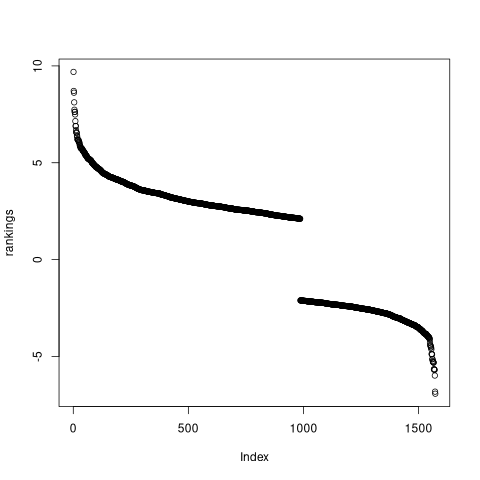

In [128]:
%%R

plot(rankings)

In [129]:
%%R

max(rankings)

[1] 9.688635


In [130]:
%%R

min(rankings)

[1] -6.923189


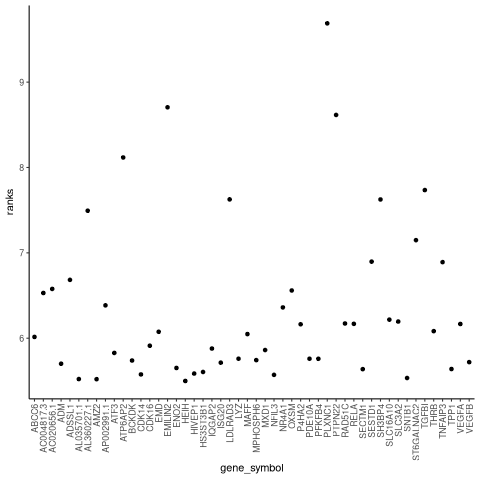

In [131]:
%%R

ggplot(data.frame(gene_symbol = names(rankings)[1:50], ranks = rankings[1:50]), aes(gene_symbol, ranks)) + 
    geom_point() +
    theme_classic() + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [132]:
%%R

head(rankings)

  PLXNC1  EMILIN2   PTPN22  ATP6AP2    TGFBI  LDLRAD3 
9.688635 8.705411 8.615688 8.117258 7.735599 7.626191 


## START GSEA

In [133]:
%%R
fgsea_OPC <- fgsea(pathways = pathwaysH, 
                  stats    = rankings,
                  scoreType = 'std',
                  minSize  = 15,
                  maxSize  = 500)

In [134]:
%%R
fgsea_OPC

                                       pathway         pval         padj
                                        <char>        <num>        <num>
 1:                      HALLMARK_ADIPOGENESIS 8.943089e-02 1.797139e-01
 2:               HALLMARK_ALLOGRAFT_REJECTION 2.541436e-01 2.983425e-01
 3:                 HALLMARK_ANDROGEN_RESPONSE 2.857143e-01 3.214286e-01
 4:                   HALLMARK_APICAL_JUNCTION 3.434343e-01 3.709091e-01
 5:                         HALLMARK_APOPTOSIS 3.143057e-02 9.429172e-02
 6:                       HALLMARK_COAGULATION 1.262940e-03 5.683230e-03
 7:                        HALLMARK_COMPLEMENT 4.867872e-02 1.314325e-01
 8: HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 2.414738e-04 1.629948e-03
 9:           HALLMARK_ESTROGEN_RESPONSE_EARLY 1.657459e-01 2.329073e-01
10:            HALLMARK_ESTROGEN_RESPONSE_LATE 9.318498e-02 1.797139e-01
11:             HALLMARK_FATTY_ACID_METABOLISM 2.113703e-01 2.594090e-01
12:                        HALLMARK_GLYCOLYSIS 4.39

In [135]:
%%R

dim(fgsea_OPC)

[1] 27  8


In [136]:
%%R
library(data.table)

fwrite(fgsea_OPC, file = "./files/fgsea_MG_FvA_logFC_cutoff.csv")

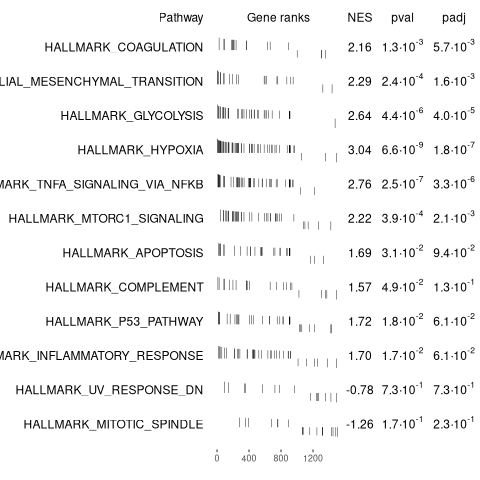

In [137]:
%%R

topUp <- fgsea_OPC %>% 
    filter(ES > 0) %>% 
    top_n(10, wt=-padj)
topDown <- fgsea_OPC %>% 
    filter(ES < 0) %>% 
    top_n(10, wt=-padj)
topPathways <- bind_rows(topUp, topDown) %>% 
    arrange(-ES)
plotGseaTable(pathwaysH[topPathways$pathway], 
              rankings, 
              fgsea_OPC, 
              gseaParam = 0.5)

In [138]:
%%R

# Filter for significant results with padj < 0.05
fgsea_OPC_significant <- fgsea_OPC %>% filter(padj < 0.1)
dim(fgsea_OPC_significant)

[1] 9 8


In [139]:
%%R

head(fgsea_OPC_significant)

                                      pathway         pval         padj
                                       <char>        <num>        <num>
1:                         HALLMARK_APOPTOSIS 3.143057e-02 9.429172e-02
2:                       HALLMARK_COAGULATION 1.262940e-03 5.683230e-03
3: HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 2.414738e-04 1.629948e-03
4:                        HALLMARK_GLYCOLYSIS 4.393712e-06 3.954341e-05
5:                           HALLMARK_HYPOXIA 6.618538e-09 1.787005e-07
6:             HALLMARK_INFLAMMATORY_RESPONSE 1.732192e-02 6.079023e-02
     log2err        ES      NES  size                             leadingEdge
       <num>     <num>    <num> <int>                                  <list>
1: 0.3217759 0.3631419 1.686832    25    RELA,ATF3,ISG20,ENO2,CLU,GADD45B,...
2: 0.4550599 0.5361535 2.155221    16       MAFF,CLU,FYN,THBD,THBS1,APOC1,...
3: 0.5188481 0.5254103 2.292246    21 TGFBI,TNFAIP3,VEGFA,ENO2,SNTB1,AREG,...
4: 0.6105269 0.5174212 2.644132   

## Explore specific gene lists?

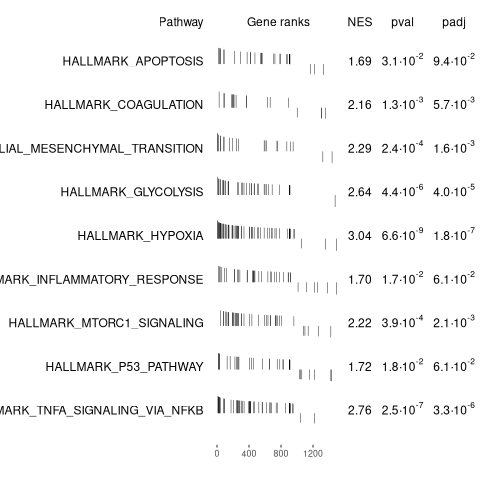

In [140]:
%%R

plotGseaTable(pathwaysH[fgsea_OPC_significant$pathway], 
              rankings, 
              fgsea_OPC_significant, 
              gseaParam = 0.5)

In [141]:
%%R

collapsedPathways <- collapsePathways(fgsea_OPC_significant[order(pval)][padj < 0.1], 
                                      pathwaysH, rankings)

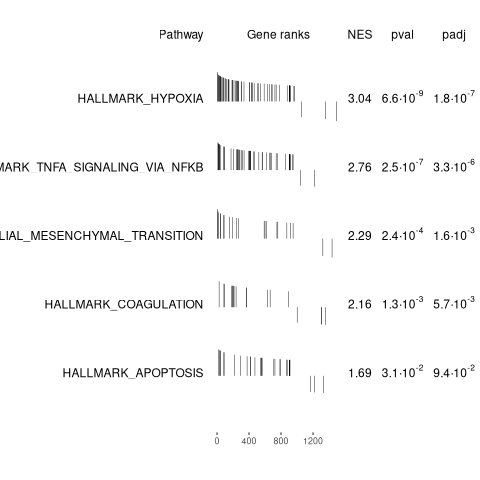

In [142]:
%%R

mainPathways <- fgsea_OPC_significant[pathway %in% collapsedPathways$mainPathways][
                         order(-NES), pathway]
plotGseaTable(pathwaysH[mainPathways], rankings, fgsea_OPC_significant, 
              gseaParam = 0.5)

In [143]:
%%R

fgseaResTidy <- fgsea_OPC %>%
  as_tibble() %>%
  arrange(desc(NES))

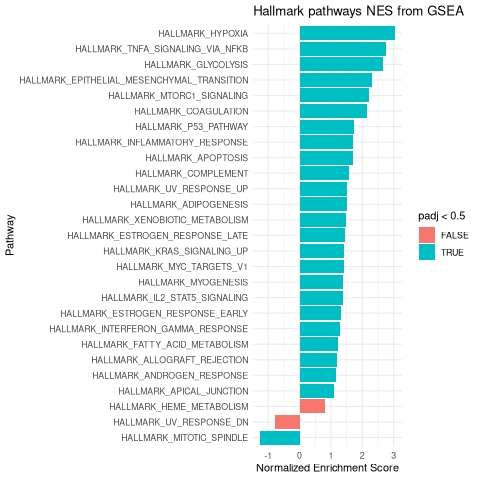

In [144]:
%%R

ggplot(fgseaResTidy, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill=padj<0.5)) +
  coord_flip() +
  labs(x="Pathway", y="Normalized Enrichment Score",
       title="Hallmark pathways NES from GSEA") + 
  theme_minimal()


#https://stephenturner.github.io/deseq-to-fgsea/#using_the_fgsea_package

In [145]:
%%R

# Subset significant results
fgseaResSignificant <- fgseaResTidy[fgseaResTidy$padj < 0.1, ]

# Select columns to display and sort by padj
fgseaResSignificant <- fgseaResSignificant[, c("pathway", "padj", "NES", "size")]
fgseaResSignificant <- fgseaResSignificant[order(fgseaResSignificant$padj), ]

# Print the table
head(fgseaResSignificant)

# A tibble: 6 × 4
  pathway                                           padj   NES  size
  <chr>                                            <dbl> <dbl> <int>
1 HALLMARK_HYPOXIA                           0.000000179  3.04    58
2 HALLMARK_TNFA_SIGNALING_VIA_NFKB           0.00000331   2.76    47
3 HALLMARK_GLYCOLYSIS                        0.0000395    2.64    33
4 HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 0.00163      2.29    21
5 HALLMARK_MTORC1_SIGNALING                  0.00208      2.22    37
6 HALLMARK_COAGULATION                       0.00568      2.16    16


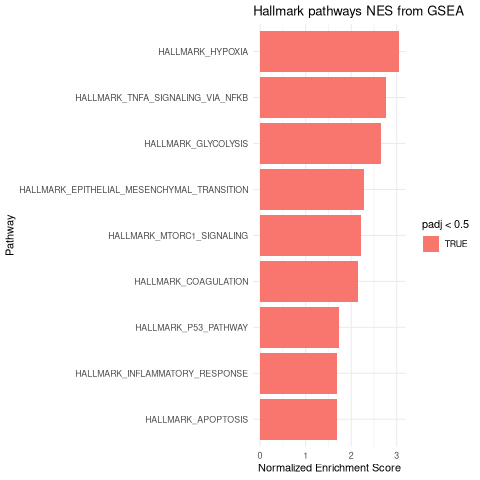

In [146]:
%%R

ggplot(fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill=padj<0.5)) +
  coord_flip() +
  labs(x="Pathway", y="Normalized Enrichment Score",
       title="Hallmark pathways NES from GSEA") + 
  theme_minimal()

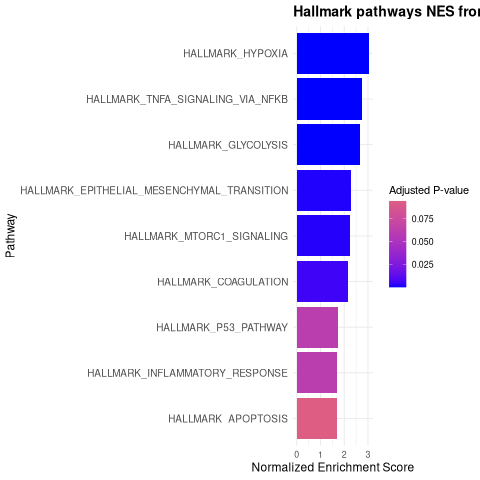

In [147]:
%%R

# Create the ggplot with a color scale for padj
ggplot(fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

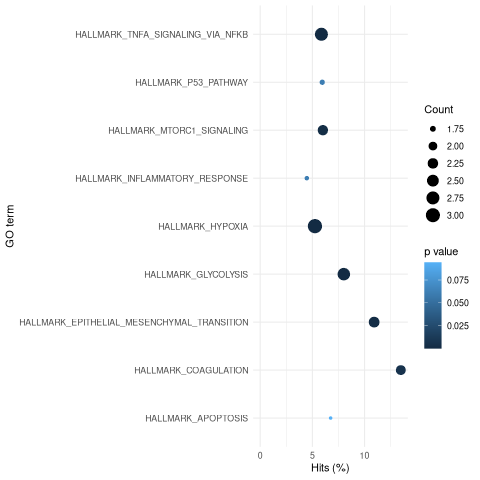

In [148]:
%%R

# Calculate hits percentage (if 'numDEInCat' and 'numInCat' equivalent are 'NES' and 'size')
fgseaResSignificant <- fgseaResSignificant %>%
  mutate(hitsPerc = NES * 100 / size)

# Ensure the columns 'padj' and 'NES' are present for the plot
fgseaResSignificant <- fgseaResSignificant %>%
  rename(term = pathway, over_represented_pvalue = padj, numDEInCat = NES)

# Create the plot
ggplot(fgseaResSignificant, aes(x = hitsPerc, y = term, colour = over_represented_pvalue, size = numDEInCat)) +
  geom_point() +
  expand_limits(x = 0) +
  labs(x = "Hits (%)", y = "GO term", colour = "p value", size = "Count") +
  theme_minimal()

#https://bioinformatics-core-shared-training.github.io/cruk-summer-school-2018/RNASeq2018/html/06_Gene_set_testing.nb.html

In [149]:
%%R

fgsea_OPC_significant

Index: <pathway>
                                      pathway         pval         padj
                                       <char>        <num>        <num>
1:                         HALLMARK_APOPTOSIS 3.143057e-02 9.429172e-02
2:                       HALLMARK_COAGULATION 1.262940e-03 5.683230e-03
3: HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 2.414738e-04 1.629948e-03
4:                        HALLMARK_GLYCOLYSIS 4.393712e-06 3.954341e-05
5:                           HALLMARK_HYPOXIA 6.618538e-09 1.787005e-07
6:             HALLMARK_INFLAMMATORY_RESPONSE 1.732192e-02 6.079023e-02
7:                  HALLMARK_MTORC1_SIGNALING 3.850237e-04 2.079128e-03
8:                       HALLMARK_P53_PATHWAY 1.801192e-02 6.079023e-02
9:           HALLMARK_TNFA_SIGNALING_VIA_NFKB 2.453572e-07 3.312322e-06
     log2err        ES      NES  size                             leadingEdge
       <num>     <num>    <num> <int>                                  <list>
1: 0.3217759 0.3631419 1.686832    

In [150]:
%%R

collapsedPathways <- collapsePathways(fgsea_OPC_significant[order(pval)][padj < 0.1], 
                                      pathwaysH, rankings)

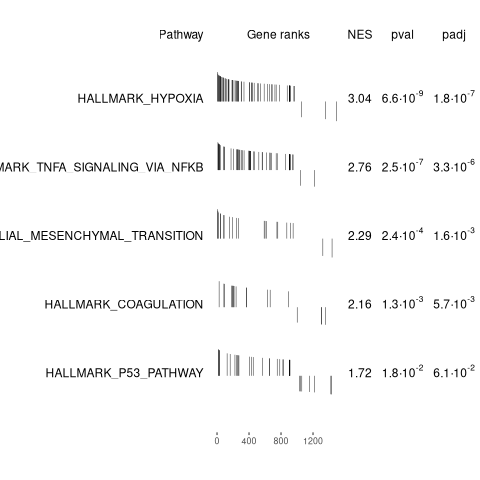

In [151]:
%%R

mainPathways <- fgsea_OPC_significant[pathway %in% collapsedPathways$mainPathways][
                         order(-NES), pathway]
plotGseaTable(pathwaysH[mainPathways], rankings, fgsea_OPC_significant, 
              gseaParam = 0.5)

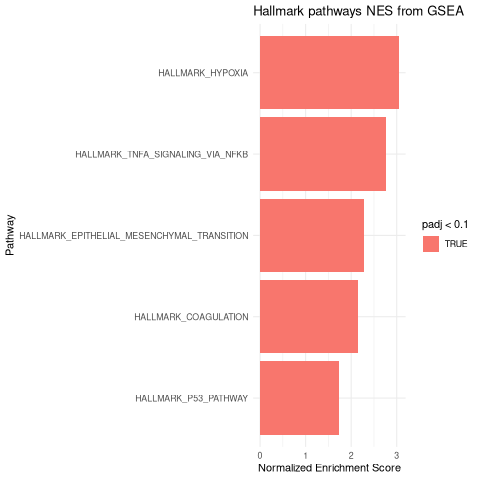

In [152]:
%%R

# Filter fgseaResSignificant to include only the main pathways from collapsedPathways
filtered_fgsea_OPC_significant <- fgsea_OPC_significant %>%
  filter(pathway %in% collapsedPathways$mainPathways)

# Create the ggplot
ggplot(filtered_fgsea_OPC_significant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj < 0.1)) +
  coord_flip() +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal()

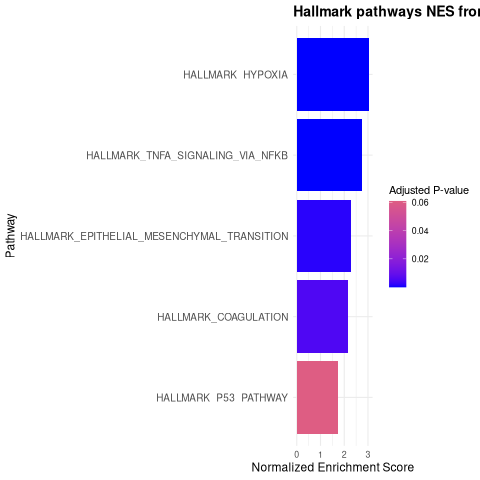

In [153]:
%%R

# Filter fgseaResSignificant to include only the main pathways from collapsedPathways
filtered_fgsea_OPC_significant <- fgsea_OPC_significant %>%
  filter(pathway %in% collapsedPathways$mainPathways)

# Create the ggplot with a color scale for padj
ggplot(filtered_fgsea_OPC_significant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

In [154]:
%%R

# Remove "HALLMARK_" prefix from the 'pathway' column
filtered_fgsea_OPC_significant$pathway <- gsub("^HALLMARK_", "", filtered_fgsea_OPC_significant$pathway)

# View the updated heatmap_df
head(filtered_fgsea_OPC_significant)

                             pathway         pval         padj   log2err
                              <char>        <num>        <num>     <num>
1:                       COAGULATION 1.262940e-03 5.683230e-03 0.4550599
2: EPITHELIAL_MESENCHYMAL_TRANSITION 2.414738e-04 1.629948e-03 0.5188481
3:                           HYPOXIA 6.618538e-09 1.787005e-07 0.7614608
4:                       P53_PATHWAY 1.801192e-02 6.079023e-02 0.3524879
5:           TNFA_SIGNALING_VIA_NFKB 2.453572e-07 3.312322e-06 0.6749629
          ES      NES  size                             leadingEdge
       <num>    <num> <int>                                  <list>
1: 0.5361535 2.155221    16       MAFF,CLU,FYN,THBD,THBS1,APOC1,...
2: 0.5254103 2.292246    21 TGFBI,TNFAIP3,VEGFA,ENO2,SNTB1,AREG,...
3: 0.5025025 3.042452    58 TGFBI,TNFAIP3,VEGFA,P4HA2,MAFF,ATF3,...
4: 0.3520322 1.724032    29  SLC3A2,RAD51C,MXD1,ATF3,PRKAB1,VDR,...
5: 0.4832024 2.756358    47  TNFAIP3,NR4A1,RELA,VEGFA,MAFF,MXD1,...


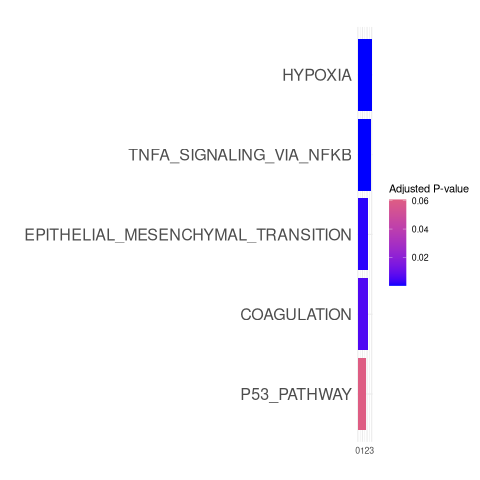

In [155]:
%%R

# Create the ggplot
plot <- ggplot(filtered_fgsea_OPC_significant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "", y = "",
       title = "") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 16),
    axis.title = element_text(size = 16),
    plot.title = element_text(size = 16, face = "bold")
  )

# Save the plot as a high-resolution PNG file
ggsave("./figures/GSEA/AL_Mg_FvA_reduced_hallmark_pathways_NES_GSEA.png", plot = plot, dpi = 300, width = 10, height = 8)

print(plot)

In [156]:
%%R

class(filtered_fgsea_OPC_significant)

[1] "data.table" "data.frame"


In [157]:
%%R

filtered_fgsea_OPC_significant <- as.data.frame(filtered_fgsea_OPC_significant)

In [158]:
%%R
library(data.table)
fwrite(filtered_fgsea_OPC_significant, file = "./files/filtered_fgsea_AL_Mg_FvA_significant.csv")

In [159]:
%%R
unique(filtered_fgsea_OPC_significant$pathway)

[1] "COAGULATION"                       "EPITHELIAL_MESENCHYMAL_TRANSITION"
[3] "HYPOXIA"                           "P53_PATHWAY"                      
[5] "TNFA_SIGNALING_VIA_NFKB"          


In [160]:
%%R

# Define the pathway of interest
pathway_of_interest <- "CHOLESTEROL_HOMEOSTASIS"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgsea_OPC_significant[filtered_fgsea_OPC_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

NULL


In [161]:
%%R
# Filter genes_down_sorted for genes in leading_edge_genes
matching_genes <- genes_up_sorted[genes_up_sorted$gene %in% leading_edge_genes, ]

# Print the filtered data frame
print(matching_genes)

# Optionally, count the number of matching genes
num_matching_genes <- nrow(matching_genes)
cat("Number of matching genes found:", num_matching_genes, "\n")

[1] gene      logFC     AveExpr   t         P.Value   adj.P.Val B        
[8] z.std     gene.1   
<0 rows> (or 0-length row.names)
Number of matching genes found: 0 


In [162]:
%%R

# Define the pathway of interest
pathway_of_interest <- "INTERFERON_GAMMA_RESPONSE"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgsea_OPC_significant[filtered_fgsea_OPC_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

NULL


In [163]:
%%R
# Filter genes_down_sorted for genes in leading_edge_genes
matching_genes <- genes_up_sorted[genes_up_sorted$gene %in% leading_edge_genes, ]

# Print the filtered data frame
print(matching_genes)

# Optionally, count the number of matching genes
num_matching_genes <- nrow(matching_genes)
cat("Number of matching genes found:", num_matching_genes, "\n")

[1] gene      logFC     AveExpr   t         P.Value   adj.P.Val B        
[8] z.std     gene.1   
<0 rows> (or 0-length row.names)
Number of matching genes found: 0 


In [164]:
%%R

# Define the pathway of interest
pathway_of_interest <- "TNFA_SIGNALING_VIA_NFKB"

# Subset the data to get the row with the specified pathway
selected_row <- filtered_fgsea_OPC_significant[filtered_fgsea_OPC_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "TNFAIP3"  "NR4A1"    "RELA"     "VEGFA"    "MAFF"     "MXD1"    
 [7] "ATF3"     "NFIL3"    "AREG"     "GADD45B"  "CCL20"    "BCL6"    
[13] "NR4A2"    "FOSL2"    "NR4A3"    "HBEGF"    "ACKR3"    "NAMPT"   
[19] "KDM6B"    "ICAM1"    "LITAF"    "TGIF1"    "EGR1"     "NFKB2"   
[25] "SOCS3"    "KYNU"     "PPP1R15A" "BTG3"     "REL"      "BCL2A1"  
[31] "PTGER4"  


In [165]:
%%R
# Filter genes_down_sorted for genes in leading_edge_genes
matching_genes <- genes_up_sorted[genes_up_sorted$gene %in% leading_edge_genes, ]

# Print the filtered data frame
print(matching_genes)

# Optionally, count the number of matching genes
num_matching_genes <- nrow(matching_genes)
cat("Number of matching genes found:", num_matching_genes, "\n")

        gene    logFC  AveExpr          t      P.Value    adj.P.Val          B
99      AREG 8.408036 1.962417  -7.554457 1.088199e-05 0.0011176574  4.0236909
24     VEGFA 6.422415 3.434458  -8.545749 6.815079e-07 0.0002792234  6.3756368
284    FOSL2 6.291722 2.857375  -8.046217 1.434093e-04 0.0050837935  1.2744495
312    ACKR3 6.056917 1.604133  -5.892772 1.675086e-04 0.0054590636  0.7389237
102  GADD45B 5.493377 2.252940  -6.640183 1.175412e-05 0.0011717244  3.6065353
34      ATF3 5.466003 2.899092  -7.991839 1.488586e-06 0.0004451749  5.6104838
297    NR4A3 5.402712 2.045764  -6.195509 1.519961e-04 0.0052036922  2.3880824
28      MAFF 5.374755 1.690919  -8.349263 8.954640e-07 0.0003251813  6.0799532
114    CCL20 4.882194 2.411380  -6.448773 1.606039e-05 0.0014295855  3.2918370
301    HBEGF 4.695063 2.017080  -7.943402 1.546236e-04 0.0052048321  1.4301105
510    SOCS3 4.607280 1.619060  -7.231748 4.974903e-04 0.0099185907  2.5403890
318    NAMPT 4.401244 6.156783  -5.747440 1.762042e-

# NEW DOTPLOT

In [166]:
%%R

# Load the data.table package
library(data.table)

# Read the files back into R
OPC_de <- fread("./files/filtered_fgsea_AL_Mg_DvA_significant.csv")
LPC_de <- fread("./files/filtered_fgsea_AL_Mg_EvA_significant.csv")
LPC_re <- fread("./files/filtered_fgsea_AL_Mg_FvA_significant.csv")

In [167]:
%%R
# For detailed differences in column names (if any)
list_columns <- list(
  OPC_de = colnames(OPC_de),
  LPC_de = colnames(LPC_de),
  LPC_re = colnames(LPC_re)
)

print(list_columns)

$OPC_de
[1] "pathway"     "pval"        "padj"        "log2err"     "ES"         
[6] "NES"         "size"        "leadingEdge"

$LPC_de
[1] "pathway"     "pval"        "padj"        "log2err"     "ES"         
[6] "NES"         "size"        "leadingEdge"

$LPC_re
[1] "pathway"     "pval"        "padj"        "log2err"     "ES"         
[6] "NES"         "size"        "leadingEdge"



In [168]:
%%R

# Subset the data frames to include only pathway, padj, NES, and size
subset_columns <- c("pathway", "NES", "padj")

OPC_de_subset <- OPC_de[, ..subset_columns]
LPC_de_subset <- LPC_de[, ..subset_columns]
LPC_re_subset <- LPC_re[, ..subset_columns]

In [169]:
%%R

# Combine the 'pathway' columns from all the data frames
all_pathways <- unique(c(OPC_de$pathway, LPC_de$pathway, LPC_re$pathway))

# Verify the unique pathways
print(head(all_pathways))

# Check the total number of unique pathways
length(all_pathways)

[1] "ADIPOGENESIS"                      "CHOLESTEROL_HOMEOSTASIS"          
[3] "EPITHELIAL_MESENCHYMAL_TRANSITION" "GLYCOLYSIS"                       
[5] "HYPOXIA"                           "IL2_STAT5_SIGNALING"              
[1] 11


In [170]:
%%R
# Function to ensure each data frame includes all pathways and fills missing ones with NaN
fill_missing_pathways <- function(df, all_pathways) {
  # Identify pathways that are missing in the current data frame
  missing_pathways <- setdiff(all_pathways, df$pathway)
  
  # Create a data frame with missing pathways, NES and padj set to NaN
  missing_data <- data.frame(pathway = missing_pathways, 
                             NES = rep(NaN, length(missing_pathways)), 
                             padj = rep(NaN, length(missing_pathways)))
  
  # Combine the original data frame with the missing pathways
  df <- rbind(df[, c("pathway", "NES", "padj")], missing_data)
  
  # Sort by pathway to maintain a consistent order
  df <- df[order(df$pathway), ]
  
  return(df)
}

# List of all unique pathways
all_pathways <- unique(c(OPC_de_subset$pathway, 
                         LPC_de_subset$pathway, LPC_re_subset$pathway))

# Apply the function to all data frames
LPC_de_filtered <- fill_missing_pathways(OPC_de_subset, all_pathways)
LPC_re_filtered <- fill_missing_pathways(LPC_de_subset, all_pathways)
Cupr_de_filtered <- fill_missing_pathways(LPC_re_subset, all_pathways)

In [171]:
%%R
LPC_de_filtered$condition <- "AL_Mg_D"
LPC_re_filtered$condition <- "AL_Mg_E"
Cupr_de_filtered$condition <- "RL_Mg_F"

# Combine all datasets into a single dataframe
combined_df <- rbind(LPC_de_filtered, LPC_re_filtered, Cupr_de_filtered)

# Verify the structure
head(combined_df)

                             pathway      NES        padj condition
                              <char>    <num>       <num>    <char>
1:                      ADIPOGENESIS 1.801784 0.029707084   AL_Mg_D
2:           CHOLESTEROL_HOMEOSTASIS 2.208436 0.003516907   AL_Mg_D
3:                       COAGULATION      NaN         NaN   AL_Mg_D
4: EPITHELIAL_MESENCHYMAL_TRANSITION 2.173398 0.004974308   AL_Mg_D
5:                        GLYCOLYSIS 2.015042 0.008093634   AL_Mg_D
6:                           HYPOXIA 2.015339 0.007971218   AL_Mg_D


In [172]:
%%R

# Remove "HALLMARK_" prefix from the 'pathway' column
combined_df$pathway <- gsub("^HALLMARK_", "", combined_df$pathway)

# View the updated heatmap_df
head(combined_df)

                             pathway      NES        padj condition
                              <char>    <num>       <num>    <char>
1:                      ADIPOGENESIS 1.801784 0.029707084   AL_Mg_D
2:           CHOLESTEROL_HOMEOSTASIS 2.208436 0.003516907   AL_Mg_D
3:                       COAGULATION      NaN         NaN   AL_Mg_D
4: EPITHELIAL_MESENCHYMAL_TRANSITION 2.173398 0.004974308   AL_Mg_D
5:                        GLYCOLYSIS 2.015042 0.008093634   AL_Mg_D
6:                           HYPOXIA 2.015339 0.007971218   AL_Mg_D


In [173]:
%%R

# Transform padj to -log10 for better visualization
combined_df$log_padj <- -log10(combined_df$padj)

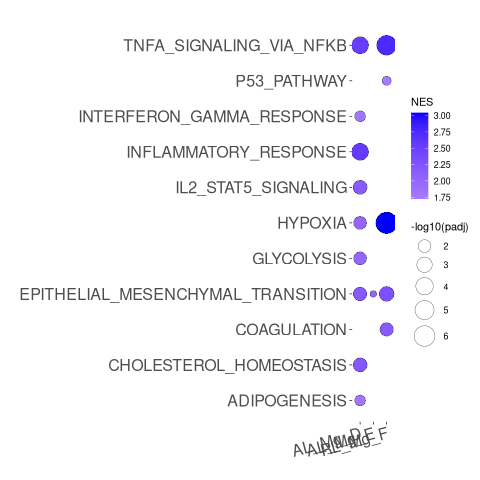

In [174]:
%%R

# Remove rows with missing or NaN values in `log_padj` or `NES`
filtered_df <- combined_df[!is.na(combined_df$log_padj) & !is.na(combined_df$NES), ]

# Set the factor levels for conditions to control the order
filtered_df$condition <- factor(filtered_df$condition, 
                                levels = c("AL_Mg_D", "AL_Mg_E", "RL_Mg_F"))

# Create the dotplot with adjustments
heatmap_plot <- ggplot(filtered_df, aes(y = pathway, x = condition, size = log_padj, fill = NES)) +
  geom_point(shape = 21, stroke = 0.2, color = "black") + # Add thin black outline to dots
  scale_fill_gradient2(low = "#c32148", mid = "white", high = "#0000FF", midpoint = 0) +
  scale_size_continuous(range = c(3, 10)) + # Increase size of dots (min=3, max=10)
  theme_minimal() +
  theme(
    panel.grid = element_blank(), # Remove grid lines
    axis.text.y = element_text(size = 16), # Adjust pathway text size
    axis.text.x = element_text(angle = 15, hjust = 1, size = 16, vjust = 1), # Adjust x-axis text spacing
    axis.ticks = element_line(linewidth = 0.3) # Adjust x-axis ticks with `linewidth`
  ) +
  labs(
    x = "", 
    y = "", 
    size = "-log10(padj)", 
    fill = "NES", 
    title = ""
  )

# Display the plot
print(heatmap_plot)

# Save the plot
#ggsave("./figures/GSEA/heatmap_pathway_NES_padj_human.png", plot = heatmap_plot, dpi = 300, width = 10, height = 8)

In [175]:
%%R
print(unique(filtered_df$pathway))

 [1] "ADIPOGENESIS"                      "CHOLESTEROL_HOMEOSTASIS"          
 [3] "EPITHELIAL_MESENCHYMAL_TRANSITION" "GLYCOLYSIS"                       
 [5] "HYPOXIA"                           "IL2_STAT5_SIGNALING"              
 [7] "INFLAMMATORY_RESPONSE"             "INTERFERON_GAMMA_RESPONSE"        
 [9] "TNFA_SIGNALING_VIA_NFKB"           "COAGULATION"                      
[11] "P53_PATHWAY"                      


In [178]:
%%R

# Define the desired order for the pathways
desired_pathway_order <- c("EPITHELIAL_MESENCHYMAL_TRANSITION",
                            "HYPOXIA",
                            "TNFA_SIGNALING_VIA_NFKB",
                            "INFLAMMATORY_RESPONSE",
                            "CHOLESTEROL_HOMEOSTASIS",
                            "IL2_STAT5_SIGNALING",
                            "GLYCOLYSIS",
                            "INTERFERON_GAMMA_RESPONSE",
                            "ADIPOGENESIS",
                            "COAGULATION",
                            "P53_PATHWAY"
                            )

# Reorder the 'pathway' column in filtered_df
filtered_df$pathway <- factor(filtered_df$pathway, levels = desired_pathway_order)

# Verify the order
print(levels(filtered_df$pathway))

 [1] "EPITHELIAL_MESENCHYMAL_TRANSITION" "HYPOXIA"                          
 [3] "TNFA_SIGNALING_VIA_NFKB"           "INFLAMMATORY_RESPONSE"            
 [5] "CHOLESTEROL_HOMEOSTASIS"           "IL2_STAT5_SIGNALING"              
 [7] "GLYCOLYSIS"                        "INTERFERON_GAMMA_RESPONSE"        
 [9] "ADIPOGENESIS"                      "COAGULATION"                      
[11] "P53_PATHWAY"                      


In [179]:
%%R
# Reverse the desired pathway order
reversed_pathway_order <- rev(desired_pathway_order)

# Reorder the 'pathway' column in filtered_df
filtered_df$pathway <- factor(filtered_df$pathway, levels = reversed_pathway_order)

# Verify the reversed order
print(levels(filtered_df$pathway))

 [1] "P53_PATHWAY"                       "COAGULATION"                      
 [3] "ADIPOGENESIS"                      "INTERFERON_GAMMA_RESPONSE"        
 [5] "GLYCOLYSIS"                        "IL2_STAT5_SIGNALING"              
 [7] "CHOLESTEROL_HOMEOSTASIS"           "INFLAMMATORY_RESPONSE"            
 [9] "TNFA_SIGNALING_VIA_NFKB"           "HYPOXIA"                          
[11] "EPITHELIAL_MESENCHYMAL_TRANSITION"


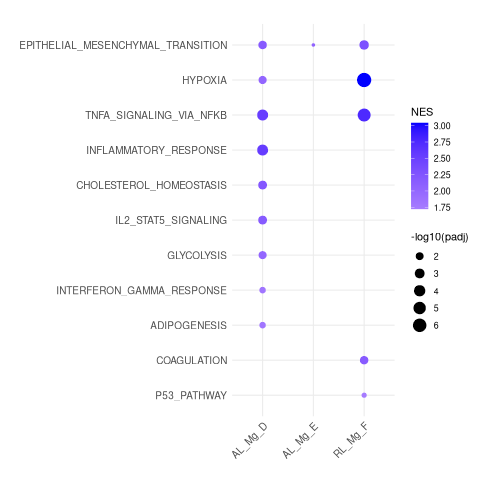

In [180]:
%%R

# Create the dotplot with switched axes and assign to heatmap_plot
heatmap_plot <- ggplot(filtered_df, aes(y = pathway, x = condition, size = log_padj, color = NES)) +
  geom_point() +
  scale_color_gradient2(low = "#c32148", mid = "white", high = "#0000FF", midpoint = 0) +
  theme_minimal() +
  theme(axis.text.y = element_text(size = 10), # Adjust pathway text size for readability
        axis.text.x = element_text(angle = 45, hjust = 1, size = 10)) + # Adjust condition text
  labs(x = "", y = "", 
       size = "-log10(padj)", color = "NES", 
       title = "")

# Show the plot
print(heatmap_plot)

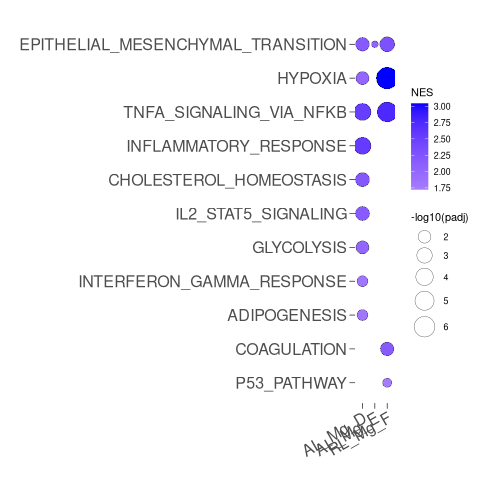

In [181]:
%%R

heatmap_plot <- ggplot(filtered_df, aes(y = pathway, x = condition, size = log_padj, fill = NES)) +
  geom_point(shape = 21, stroke = 0.2, color = "black") +
  scale_fill_gradient2(low = "#c32148", mid = "white", high = "#0000FF", midpoint = 0) +
  scale_size_continuous(range = c(3, 10)) +
  theme_minimal() +
  theme(
    panel.grid = element_blank(),
    axis.text.y = element_text(size = 16, vjust = 0.5),
    axis.text.x = element_text(angle = 30, hjust = 1, size = 16, vjust = 1),
    axis.ticks = element_line(linewidth = 0.3),
    axis.ticks.length = unit(0.2, "cm")
  ) +
  labs(
    x = "", 
    y = "", 
    size = "-log10(padj)", 
    fill = "NES", 
    title = ""
  )

print(heatmap_plot)

ggsave("./figures/GSEA/heatmap_pathway_NES_padj_MG_ordered.png", plot = heatmap_plot, dpi = 300, width = 10, height = 8)

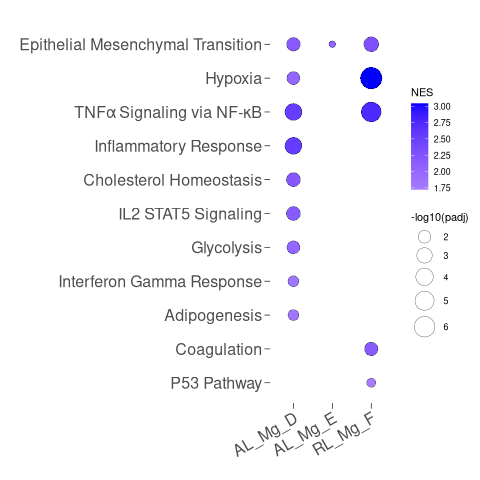

In [183]:
%%R

# Reverse the desired pathway order
reversed_pathway_order <- rev(desired_pathway_order)

# Create a named vector to map original pathway names to formatted ones
pathway_labels <- c(
  "EPITHELIAL_MESENCHYMAL_TRANSITION" = "Epithelial Mesenchymal Transition",
  "TNFA_SIGNALING_VIA_NFKB" = "TNFα Signaling via NF-κB",
  "HYPOXIA" = "Hypoxia",
  "GLYCOLYSIS" = "Glycolysis",
  "INFLAMMATORY_RESPONSE" = "Inflammatory Response",
  "INTERFERON_GAMMA_RESPONSE" = "Interferon Gamma Response",
  "CHOLESTEROL_HOMEOSTASIS" = "Cholesterol Homeostasis",
  "COAGULATION" = "Coagulation",
    "P53_PATHWAY"= "P53 Pathway",
    "IL2_STAT5_SIGNALING"= "IL2 STAT5 Signaling",
    "ADIPOGENESIS"= "Adipogenesis"
)

# Apply the reversed order and formatted names to the 'pathway' column
filtered_df$pathway <- factor(filtered_df$pathway, 
                              levels = reversed_pathway_order, 
                              labels = pathway_labels[reversed_pathway_order])

# Create the heatmap plot
heatmap_plot <- ggplot(filtered_df, aes(y = pathway, x = condition, size = log_padj, fill = NES)) +
  geom_point(shape = 21, stroke = 0.2, color = "black") +
  scale_fill_gradient2(low = "#c32148", mid = "white", high = "#0000FF", midpoint = 0) +
  scale_size_continuous(range = c(3, 10)) +
  theme_minimal() +
  theme(
    panel.grid = element_blank(),  # Remove grid lines
    axis.text.y = element_text(size = 16, vjust = 0.5),
    axis.text.x = element_text(angle = 30, hjust = 1, size = 16, vjust = 1),
    axis.ticks = element_line(linewidth = 0.3),
    axis.ticks.length = unit(0.2, "cm")
  ) +
  labs(
    x = "", 
    y = "", 
    size = "-log10(padj)", 
    fill = "NES", 
    title = ""
  )


# Save the plot
ggsave("./figures/GSEA/heatmap_pathway_NES_padj_MG_only_ordered_NEW.png", 
       plot = heatmap_plot, dpi = 300, width = 7.5, height = 8)

# Print the plot
print(heatmap_plot)